# Load models and analyse properties of final states

### Import utility and functions

In [4]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns             # for heatmaps, clustering plots
import quimb as qu                # only if you want to compare to exact state
import sonnet as snt
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator

# your existing utilities:
from compgraph.tensorflow_version.model_loading import extract_hyperparams_from_path, load_model_from_path
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
from compgraph.monte_carlo import MCMCSampler
from compgraph.quimb_helpers.operators import calculate_site_magnetizations_square  # the quimb version
def extract_run_data(path, base_dir=None, tags=("training/energy_real", "training/std_energy", "training/staggered_magnetization_abs")):
    """
    Load the latest TensorBoard event file in the given path and extract time-series data for each tag.
    Returns a dict suitable for aggregation into a DataFrame, with series as lists.
    """
    # A) Pick latest event file
    event_files = glob.glob(os.path.join(path, "events.out.tfevents.*"))
    if not event_files:
        raise FileNotFoundError(f"No event files found in {path}")

    latest_file = max(event_files, key=os.path.getmtime)

    # B) Extract run name (relative to some root)
    run_name = os.path.relpath(path, base_dir) if base_dir else path

    # C) Load tensor events
    ea = event_accumulator.EventAccumulator(latest_file, size_guidance={"tensors": 0})
    ea.Reload()

    available = ea.Tags().get("tensors", [])
    record = {"run_name": run_name}

    for tag in tags:
        if tag not in available:
            print(f"Warning: Tag '{tag}' not found in {latest_file}")
            record[tag] = []
            continue

        steps = []
        values = []

        for evt in ea.Tensors(tag):
            try:
                val = tf.make_ndarray(evt.tensor_proto).item()
            except Exception as e:
                print(f"Error decoding {tag} @ step {evt.step}: {e}")
                continue
            steps.append(evt.step)
            values.append(val)

        record[tag] = values
        if "steps" not in record:
            record["steps"] = steps

    return record


def batch_extract(paths, tags=("training/energy_real", "training/std_energy", "training/staggered_magnetization_abs")):
    """
    Apply extract_run_data to a list of run paths and return a combined DataFrame.
    """
    base_dir = os.path.commonpath(paths)
    results = []

    for p in paths:
        try:
            row = extract_run_data(p, base_dir=base_dir, tags=tags)
            results.append(row)
        except Exception as e:
            print(f"Skipping {p}: {e}")

    return pd.DataFrame(results)


# Analyse 3x3

In [11]:
import re
# List of run directories containing TensorBoard events & checkpoints:
# all_checkpoints = glob.glob("checkpointed_logs/**/checkpoints", recursive=True)
run_dirs = glob.glob("checkpointed_logs/**/GNN*", recursive=True)

filtered_dirs = [ckpt for ckpt in run_dirs if re.search(r'03_03', ckpt)]
checkpoint_dirs = [f"{path}checkpoints" for path in filtered_dirs]
df_runs = batch_extract(filtered_dirs,  tags=("training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
                                              "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2","configuration/hyperparameters"))

In [12]:
# Step 1: Decode byte strings to regular strings
df_runs['config_str'] = df_runs['configuration/hyperparameters'].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))

# Step 2: Extract seed if present
df_runs['seed'] = df_runs['config_str'].apply(
    lambda s: int(re.search(r'seed:\s*(\d+)', s).group(1)) if re.search(r'seed:\s*(\d+)', s) else np.nan
)

df_runs["final_energy"] = df_runs["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_std"]    = df_runs["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_stagg"]  = df_runs["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
min_iterations=1000
df_runs_seeded=df_runs[~df_runs['seed'].isna()]
df_runs_filtered = df_runs_seeded[df_runs_seeded['training/energy_real'].apply(len) >= min_iterations].copy()


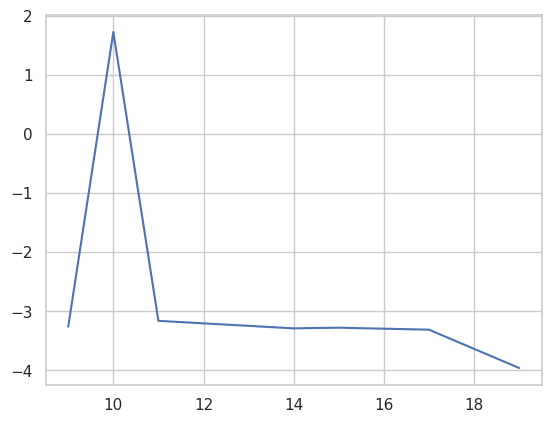

In [13]:
import matplotlib.pyplot as plt
plt.plot(df_runs_seeded["final_energy"])

In [14]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # for aesthetics and potentially different plot types


def safe_decode(x):
    try:
        return x.decode() if isinstance(x, bytes) else str(x)
    except: 
        return str(x) # Fallback

def extract_specific_hyperparams(config_str):
    hyperparams = {}
    # Regex to find specific parameters. Adjust patterns based on your config string format.
    beta_match = re.search(r'beta:\s*(\d+\.?\d*)', config_str)
    lr_match = re.search(r'learning_rate:\s*(\d+\.?\d*[eE]?-?\d*)', config_str)
    gnn_match = re.search(r'(GNN\d+adv|GNNprocnorm)_h\d+_e\d+_K\d+', config_str) # Example GNN architecture match

    hyperparams['beta'] = float(beta_match.group(1)) if beta_match else np.nan
    hyperparams['lr'] = float(lr_match.group(1)) if lr_match else np.nan

    return hyperparams
df_runs_seeded_copy= df_runs_seeded.copy()
# Apply extraction
df_runs_seeded_copy['config_str'] = df_runs_seeded_copy['configuration/hyperparameters'].apply(safe_decode)
hyperparams_df = df_runs_seeded_copy['config_str'].apply(lambda s: pd.Series(extract_specific_hyperparams(s)))
df_runs_seeded_copy = pd.concat([df_runs_seeded_copy, hyperparams_df], axis=1)

# Filter out runs without seed or insufficient iterations
min_iterations = 1000
df_runs_seeded_copy_filtered = df_runs_seeded_copy[~df_runs_seeded_copy['seed'].isna()]
df_runs_seeded_copy_filtered = df_runs_seeded_copy_filtered[df_runs_seeded_copy_filtered['training/energy_real'].apply(len) >= min_iterations].copy()

# Add final values
df_runs_seeded_copy_filtered["final_energy"] = df_runs_seeded_copy_filtered["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_seeded_copy_filtered["final_std"]    = df_runs_seeded_copy_filtered["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_seeded_copy_filtered["final_stagg"]  = df_runs_seeded_copy_filtered["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)

print(f"Original runs: {len(df_runs_seeded_copy)}")
print(f"Runs after filtering (seed and >= {min_iterations} iterations): {len(df_runs_seeded_copy_filtered)}")

# Define exact values for 4x4
exact_energy = -3.96# Your value from the plot


Original runs: 7
Runs after filtering (seed and >= 1000 iterations): 6


In [15]:
df_runs_seeded_copy_filtered_low_energy=df_runs_seeded_copy_filtered[df_runs_seeded_copy_filtered['final_energy'] < -3]
df_runs_seeded_copy_filtered_low_energy['run_name'].unique().tolist()
# 3) filtro
dirs_lowE = [
    d for d in filtered_dirs
    if any(run in d for run in df_runs_seeded_copy_filtered_low_energy['run_name'].unique().tolist())
]

print(f"Trovate {len(dirs_lowE)} directory low-energy:" , dirs_lowE)

Trovate 6 directory low-energy: ['checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.007__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3', 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.07__bs_256lr1.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K2', 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.07__bs_64lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2', 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.1__bs_64lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2', 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3', 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Alternatepattern/beta0.1__bs_64lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K1']


In [17]:
dirs_lowE

['checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.007__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.07__bs_256lr1.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K2',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.07__bs_64lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.1__bs_64lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Disordered/beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Alternatepattern/beta0.1__bs_64lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K1']

<Figure size 1400x1200 with 0 Axes>

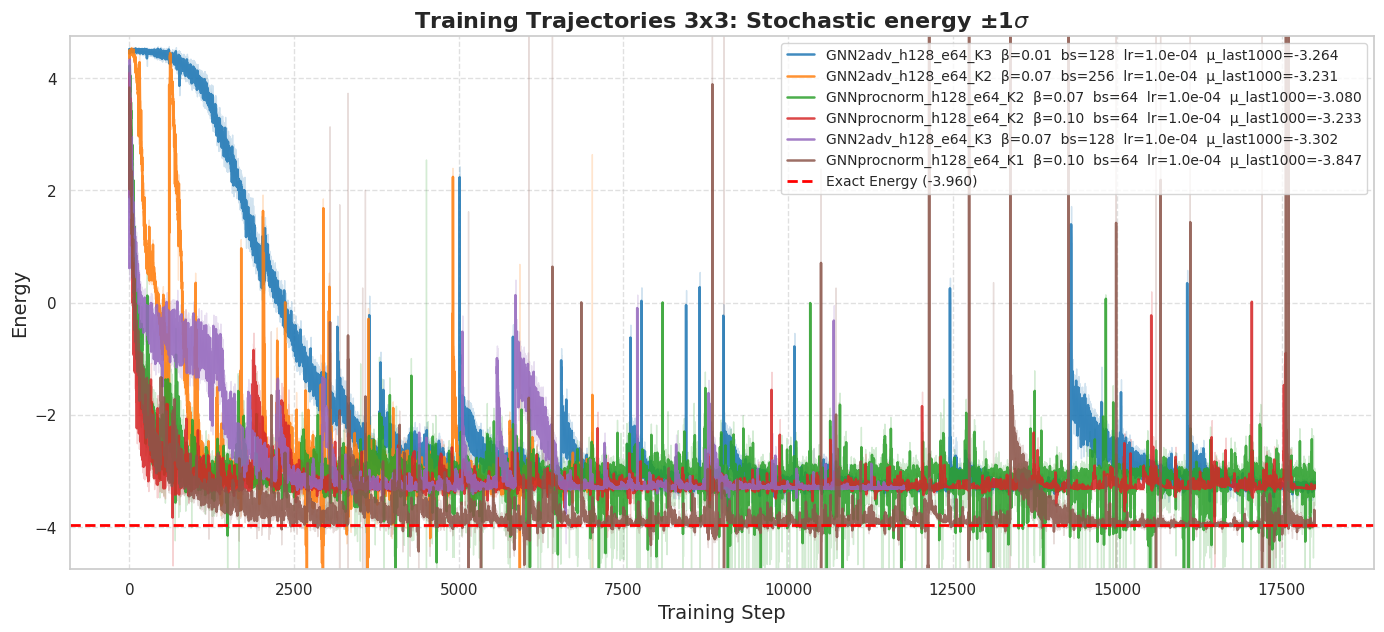

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
df = df_runs_seeded_copy_filtered.copy()

# Set seaborn style for prettier plots
sns.set_theme(style="whitegrid")

title_n=f"Training Trajectories {3}x{3}: Stochastic energy ±1" + r"$\sigma$"

plt.figure(figsize=(14, 12))

# calculate how far below exact_energy to clip
offset = 0.2 * abs(exact_energy)
ymin = exact_energy - offset

# get a categorical palette
palette = sns.color_palette("tab10", n_colors=len(df_runs_seeded_copy_filtered_low_energy))

plt.figure(figsize=(14, 12))
ax1 = plt.subplot(2, 1, 1)

for (idx, run_data), color in zip(df_runs_seeded_copy_filtered_low_energy.iterrows(), palette):
    steps       = np.array(run_data['steps'])
    energy      = np.array(run_data['training/energy_real'])
    std_energy  = np.array(run_data['training/std_energy'])
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # extract a simpler run name
    run_name   = run_data.get('run_name', str(idx))
    m          = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name= m.group(0) if m else run_name.split('/')[-1]

    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

# 3. exact energy line
ax1.axhline(y=exact_energy,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ({exact_energy:.3f})')

# 4. clip y-axis to 20% below the ground truth
ax1.set_ylim(bottom=ymin,top=-ymin)
ax1.set_title(title_n, fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## Analyze 4x4 results

### Loading them

In [168]:
import re
# List of run directories containing TensorBoard events & checkpoints:
# all_checkpoints = glob.glob("checkpointed_logs/**/checkpoints", recursive=True)
run_dirs = glob.glob("checkpointed_logs/**/GNN*", recursive=True)

filtered_dirs = [ckpt for ckpt in run_dirs if re.search(r'04_04', ckpt)]
checkpoint_dirs = [f"{path}checkpoints" for path in filtered_dirs]

n_sites = 16   # for 4×4
n_samples = 5_000   # number of MC samples to draw per run
thermalization = 500 * n_sites

df_runs = batch_extract(filtered_dirs,  tags=("training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
                                              "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2","configuration/hyperparameters"))

In [235]:
len(filtered_dirs)

31

In [ ]:
# Step 1: Decode byte strings to regular strings
df_runs['config_str'] = df_runs['configuration/hyperparameters'].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))

# Step 2: Extract seed if present
df_runs['seed'] = df_runs['config_str'].apply(
    lambda s: int(re.search(r'seed:\s*(\d+)', s).group(1)) if re.search(r'seed:\s*(\d+)', s) else np.nan
)

df_runs["final_energy"] = df_runs["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_std"]    = df_runs["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_stagg"]  = df_runs["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
min_iterations=1000
df_runs_seeded=df_runs[~df_runs['seed'].isna()]
df_runs_filtered = df_runs_seeded[df_runs_seeded['training/energy_real'].apply(len) >= min_iterations].copy()


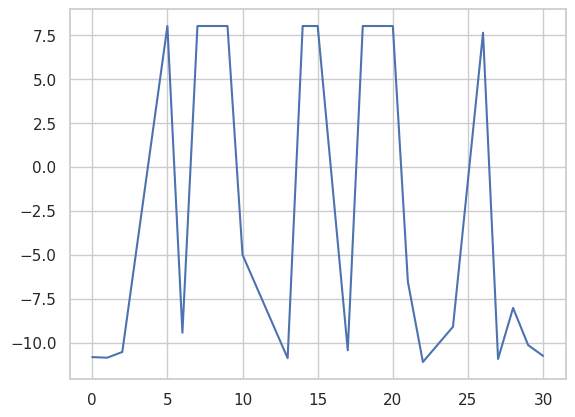

In [173]:
plt.plot(df_runs_seeded["final_energy"])

In [176]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # for aesthetics and potentially different plot types


def safe_decode(x):
    try:
        return x.decode() if isinstance(x, bytes) else str(x)
    except: 
        return str(x) # Fallback

def extract_specific_hyperparams(config_str):
    hyperparams = {}
    # Regex to find specific parameters. Adjust patterns based on your config string format.
    beta_match = re.search(r'beta:\s*(\d+\.?\d*)', config_str)
    lr_match = re.search(r'learning_rate:\s*(\d+\.?\d*[eE]?-?\d*)', config_str)
    gnn_match = re.search(r'(GNN\d+adv|GNNprocnorm)_h\d+_e\d+_K\d+', config_str) # Example GNN architecture match

    hyperparams['beta'] = float(beta_match.group(1)) if beta_match else np.nan
    hyperparams['lr'] = float(lr_match.group(1)) if lr_match else np.nan

    return hyperparams
df_runs_seeded_copy= df_runs_seeded.copy()
# Apply extraction
df_runs_seeded_copy['config_str'] = df_runs_seeded_copy['configuration/hyperparameters'].apply(safe_decode)
hyperparams_df = df_runs_seeded_copy['config_str'].apply(lambda s: pd.Series(extract_specific_hyperparams(s)))
df_runs_seeded_copy = pd.concat([df_runs_seeded_copy, hyperparams_df], axis=1)

# Filter out runs without seed or insufficient iterations
min_iterations = 1000
df_runs_seeded_copy_filtered = df_runs_seeded_copy[~df_runs_seeded_copy['seed'].isna()]
df_runs_seeded_copy_filtered = df_runs_seeded_copy_filtered[df_runs_seeded_copy_filtered['training/energy_real'].apply(len) >= min_iterations].copy()

# Add final values
df_runs_seeded_copy_filtered["final_energy"] = df_runs_seeded_copy_filtered["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_seeded_copy_filtered["final_std"]    = df_runs_seeded_copy_filtered["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_seeded_copy_filtered["final_stagg"]  = df_runs_seeded_copy_filtered["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)

print(f"Original runs: {len(df_runs_seeded_copy)}")
print(f"Runs after filtering (seed and >= {min_iterations} iterations): {len(df_runs_seeded_copy_filtered)}")

# Define exact values for 4x4
exact_energy = -11.228 # Your value from the plot
exact_stagg_abs = 0.517 # Your value from the plot

Original runs: 22
Runs after filtering (seed and >= 1000 iterations): 20


### Loading a specific model which has low energy

In [20]:
import tensorflow as tf

def batch_staggered_metrics_pm1(spins_pm1, eps_pm1):
    """
    spins_pm1:  (B, N) tf.float32, values ±1
    eps_pm1:    (N,)   tf.float32, values ±1
    Returns dict with m_rms, m_abs, S_pp
    """
    spins = tf.convert_to_tensor(spins_pm1, tf.float32)     # (B,N)
    eps   = tf.convert_to_tensor(eps_pm1,   tf.float32)     # (N,)

    N     = tf.cast(tf.shape(spins)[1], tf.float32)         # 16 for 4×4
    Ms    = tf.reduce_sum(spins * eps[None,:], axis=1)      # (B,)

    Ms2   = tf.reduce_mean(tf.square(Ms))                   # ⟨Ms²⟩_batch
    m_rms = tf.sqrt(Ms2) / N
    m_abs = tf.reduce_mean(tf.abs(Ms)) / N
    S_pp  = Ms2 / N

    return m_rms, m_abs, S_pp


In [2]:
## Exact Quimb
import numpy as np, quimb as qu

# 2a) Build and diagonalize 4×4 Heisenberg
n = m = 4
H = qu.ham_heis_2D(n, m, j=1.0, cyclic=True, sparse=True)
E0= qu.groundenergy(H)
psi0 = qu.groundstate(H)  # ground state vector

# 2b) Build checkerboard ε_i = ±1
eps = np.array([1 if (x+y)%2==0 else -1
                for x in range(n) for y in range(m)])  # shape (16,)

# 2c) Enumerate basis spins in ±1 convention
N = n*m
basis = ((np.arange(2**N)[:,None] >> np.arange(N)) & 1)*2 - 1   # (2^16,16)
probs = np.abs(psi0)**2                                       # (2^16,)

# 2d) Compute Ms for each config in ±1 units
Ms_vals = (basis * eps[None,:]).sum(axis=1)                 # (65536,)
Ms    = np.dot(probs.flatten(), Ms_vals)                             # should be ≈ 0
Ms2    = np.dot(probs.flatten(), Ms_vals**2)

# 2e) Extract the per-site observables
m_rms_quimb = np.sqrt(Ms2) / N
m_abs_quimb = np.dot(probs.flatten(), np.abs(Ms_vals)) / N
Spp_quimb   = Ms2 / N

print("Quimb baseline:", m_rms_quimb, m_abs_quimb, Spp_quimb)

Quimb baseline: 0.607209064615308 0.5173775227073758 5.899245570415956


In [136]:
# 4a)  a batch of size B from the exact |ψ0|²
B     = 2048
inds  = np.random.choice(2**N, size=B, p=probs.flatten())
batch = basis[inds]                          # shape (B,16), ±1
eps16 = eps                                  # shape (16,)

# 4b) Compute TF metrics
m_rms_tf, m_abs_tf, Spp_tf = batch_staggered_metrics_pm1(batch, eps16)

print("TF on exact batch:",
      float(m_rms_tf.numpy()),
      float(m_abs_tf.numpy()),
      float(Spp_tf.numpy()))
print("Quimb baseline:",
      m_rms_quimb,
      m_abs_quimb,
      Spp_quimb)
# 4c) Assert they match the Quimb baseline within ~1e-2
assert abs(m_rms_tf - m_rms_quimb) < 1e-2
assert abs(m_abs_tf - m_abs_quimb) < 1e-2


TF on exact batch: 0.6100257039070129 0.5205078125 5.9541015625
Quimb baseline: 0.6072090646153094 0.5173775227073778 5.899245570415985


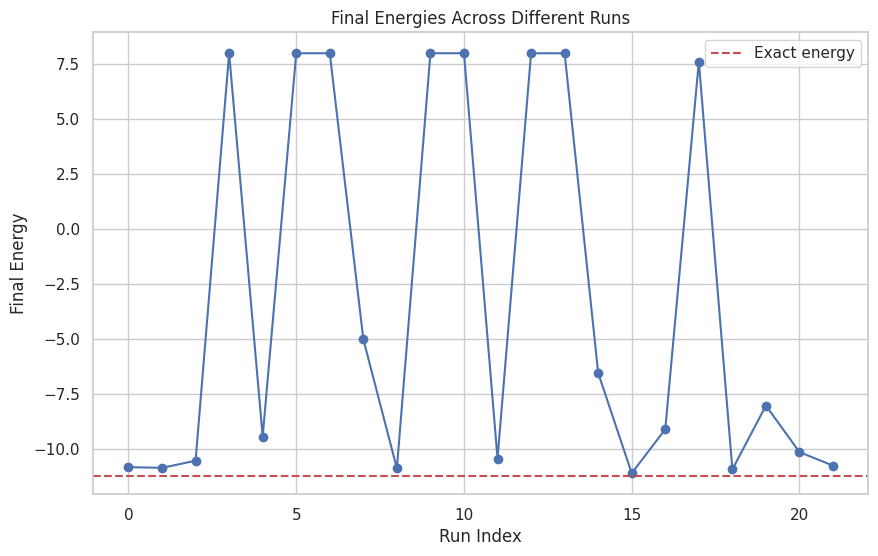

In [177]:
# Create a list of final energies from all runs
# Use final_energy column that was already computed in CELL INDEX: 9
energies_list = df_runs_seeded['final_energy'].values
plt.figure(figsize=(10, 6))
plt.plot(energies_list, 'o-')
plt.axhline(y=-11.23, color='r', linestyle='--', label='Exact energy')
plt.ylabel('Final Energy')
plt.xlabel('Run Index')
plt.title('Final Energies Across Different Runs')
plt.grid(True)
plt.legend()

In [185]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import re

# # Assuming df_runs_seeded is already created as in your notebook

# # Define exact values for 4x4 from your quimb calculations
# exact_energy =ge # E0/N
# exact_stagg_abs = m_abs_quimb # m_abs from quimb output
# exact_stagg_sqrt = m_rms_quimb # m_rms from quimb output
# # Select a few runs to plot trajectories for
# # You might want to manually pick based on final energy or hyperparameters
# # For example, select the run with the lowest final energy:
# best_run_idx = df_runs_seeded['final_energy'].idxmin()
# # Select a couple of other runs
# other_run_indices = df_runs_seeded.sample(19).index.tolist()
# runs_to_plot = [best_run_idx] + other_run_indices # Ensure unique indices

# plt.figure(figsize=(14, 10))

# for idx in runs_to_plot:
#     run_data = df_runs_seeded.loc[idx]
#     steps = run_data['steps']
#     energy = run_data['training/energy_real']
#     run_name = run_data['run_name'] # Use run_name or extract key hyperparams
#     print(run_name)
#     # Extract simplified run identifier for legend
#     # You might need to adjust this based on your run_name structure
#     # Example: extract part of the path or key hyperparams
#     match = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
#     simple_name = match.group(0) if match else run_name.split('/')[-1]

#     # Plot Energy
#     plt.subplot(2, 1, 1)
#     plt.plot(steps, energy, label=f'Energy - {simple_name}', alpha=0.8)



# # Add exact energy line
# plt.subplot(2, 1, 1)
# plt.axhline(y=exact_energy, color='r', linestyle='--', label=f'Exact Energy from ED ({exact_energy:.3f})')
# plt.ylabel('Energy')
# plt.xlabel('Training Step')
# plt.title('Training Trajectories: Energy')
# plt.legend()
# plt.grid(True)



# plt.tight_layout()
# plt.show()

### Selection of plots to show

In [238]:
import re
import sys

df = df_runs_seeded_copy_filtered.copy()
df['arch_match'] = df['run_name'].str.split('/').str[-1]

# 1) Choose architecture
print("Available architectures:\n", df['arch_match'].unique().tolist(), flush=True)
sel_arch = input("→ Select one architecture: ").strip()
print("You picked:", sel_arch, flush=True)
df = df[df['arch_match'] == sel_arch]

# 2) Extract batch-size
df['bs'] = (
    df['run_name']
      .str.extract(r'__bs_(\d+)lr', expand=False)
      .astype(int)
)

# 3) Fix one hyperparameter
params = ['beta', 'lr', 'bs']
print("\nHyperparameters you can fix:\n 1) all   2) beta   3) lr   4) bs", flush=True)
choice = input("→ Type one of [all, beta, lr, bs]: ").strip()
print("You chose to fix:", choice, "\n", flush=True)

if choice == 'all':
    runs_to_plot_df = df.copy()
else:
    # 3a) gather unique values
    vals = sorted(df[choice].unique().tolist())
    print(f"Found these {choice} values: {vals}", flush=True)

    # 3b) for each, print combos of the other two
    others = [p for p in params if p != choice]
    for v in vals:
        subset = df[df[choice] == v]
        combo_df = subset.groupby(others).size().reset_index()[others]
        print(f"\n{choice} = {v!r}  →  combinations of {others}:", flush=True)
        for _, row in combo_df.iterrows():
            print("   •", {p: row[p] for p in others}, flush=True)

    # 3c) ***now*** ask which value to fix
    fixed_val = input(f"\nEnter the {choice} you want to fix: ").strip()
    fixed_val = float(fixed_val) if choice in ('beta','lr') else int(fixed_val)
    print(f"You fixed {choice} = {fixed_val!r}", flush=True)

    runs_to_plot_df = df[df[choice] == fixed_val].copy()

# 4) Title
if choice == 'all':
    title_n = f"Training Trajectories ({sel_arch} — all β, lr, bs)  Stochastic energy ±1σ"
else:
    others = [p for p in params if p != choice]
    title_n = (
        f"Training Trajectories ({sel_arch} — fix {choice}={fixed_val}, "
        f"vary {others[0]} & {others[1]})  Stochastic energy ±1σ"
    )

print(f"\nSelected runs: {len(runs_to_plot_df)}", flush=True)
print("Plot title will be:", title_n, flush=True)


Available architectures:
 ['GNNprocnorm_h128_e64_K2', 'GNN2adv_h128_e64_K3', 'GNN2adv_h128_e64_K1', 'GNN2adv_h128_e64_K2']
You picked: GNNprocnorm_h128_e64_K2

Hyperparameters you can fix:
 1) all   2) beta   3) lr   4) bs
You chose to fix: all 


Selected runs: 4
Plot title will be: Training Trajectories (GNNprocnorm_h128_e64_K2 — all β, lr, bs)  Stochastic energy ±1σ


In [233]:
runs_to_plot_df.sort_values(by='final_energy', inplace=True)

<Figure size 1400x1200 with 0 Axes>

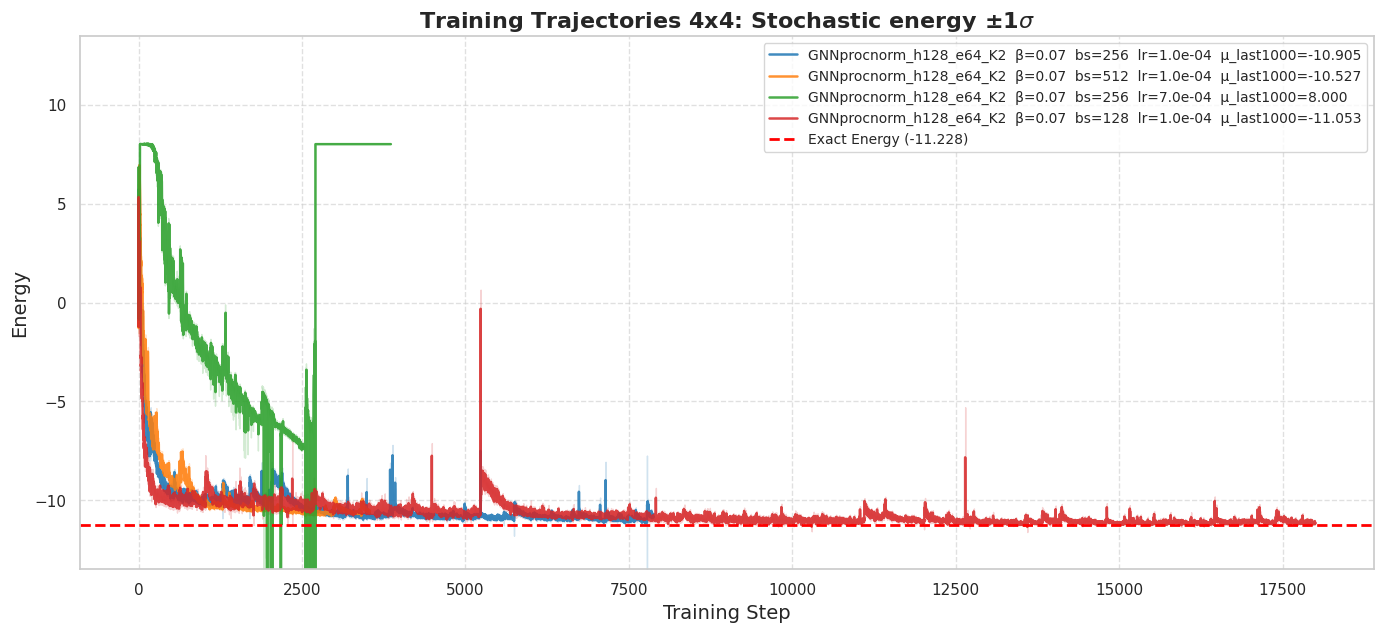

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
df = df_runs_seeded_copy_filtered.copy()

# Set seaborn style for prettier plots
sns.set_theme(style="whitegrid")

title_n=f"Training Trajectories {n}x{n}: Stochastic energy ±1" + r"$\sigma$"

plt.figure(figsize=(14, 12))

# calculate how far below exact_energy to clip
offset = 0.2 * abs(exact_energy)
ymin = exact_energy - offset

# get a categorical palette
palette = sns.color_palette("tab10", n_colors=len(runs_to_plot_df))

plt.figure(figsize=(14, 12))
ax1 = plt.subplot(2, 1, 1)

for (idx, run_data), color in zip(runs_to_plot_df.iterrows(), palette):
    steps       = np.array(run_data['steps'])
    energy      = np.array(run_data['training/energy_real'])
    std_energy  = np.array(run_data['training/std_energy'])
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # extract a simpler run name
    run_name   = run_data.get('run_name', str(idx))
    m          = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name= m.group(0) if m else run_name.split('/')[-1]

    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

# 3. exact energy line
ax1.axhline(y=exact_energy,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ({exact_energy:.3f})')

# 4. clip y-axis to 20% below the ground truth
ax1.set_ylim(bottom=ymin,top=-ymin)
ax1.set_title(title_n, fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_3113084/4003891311.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_means, y=run_labels, palette="tab10", orient='h')


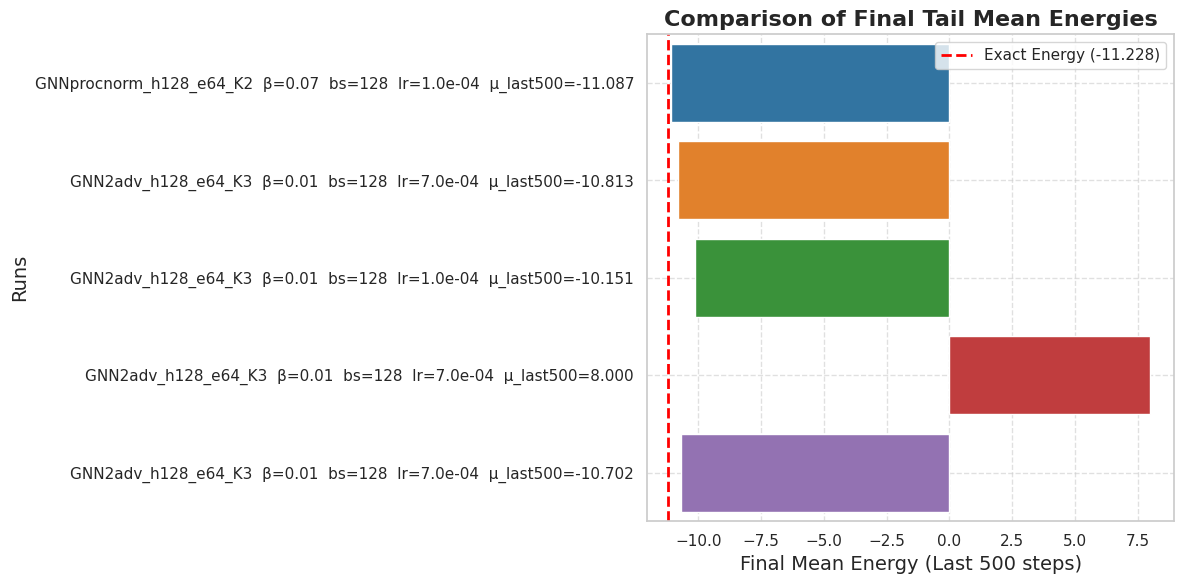

In [197]:
tail_length = 500  # Tail size you want to use for mean calculation

# --- Collect final means for additional tail plot ---
final_means = []
run_labels  = []

for (idx, run_data), color in zip(runs_to_plot_df.iterrows(), palette):
    steps      = np.array(run_data['steps'])
    energy     = np.array(run_data['training/energy_real'])
    std_energy = np.array(run_data['training/std_energy'])

    # Compute mean over last N points
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # --- Parse run name ---
    run_name = run_data.get('run_name', str(idx))
    m = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name = m.group(0) if m else run_name.split('/')[-1]

    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    # Plot energy curve
    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

    # --- Save final mean and label for tail plot ---
    final_means.append(final_mean)
    run_labels.append(label)

# --- Setup after first plot ---
ax1.axhline(y=exact_energy,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ({exact_energy:.3f})')
ax1.set_ylim(bottom=exact_energy - 0.2 * abs(exact_energy))
ax1.set_title('Training Trajectories: Energy ±1 SD', fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# ===================================================
# --- Extra Plot: Tail Mean Energies per Run ---
# ===================================================

plt.figure(figsize=(12, 6))
sns.barplot(x=final_means, y=run_labels, palette="tab10", orient='h')
plt.axvline(x=exact_energy, color='red', linestyle='--', linewidth=2, label=f'Exact Energy ({exact_energy:.3f})')

plt.xlabel(f'Final Mean Energy (Last {tail_length} steps)', fontsize=14)
plt.ylabel('Runs', fontsize=14)
plt.title('Comparison of Final Tail Mean Energies', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Selection of models

In [ ]:
df_runs_seeded_copy_filtered_low_energy=df_runs_seeded_copy_filtered[df_runs_seeded_copy_filtered['final_energy'] < -10.8]
df_runs_seeded_copy_filtered_low_energy['run_name'].unique().tolist()
# 3) filtro
dirs_lowE = [
    d for d in filtered_dirs
    if any(run in d for run in df_runs_seeded_copy_filtered_low_energy['run_name'].unique().tolist())
]

print(f"Trovate {len(dirs_lowE)} directory low-energy:" , dirs_lowE)

['beta0.07__bs_256lr1.0e-04_loop1210x30_overlap_VMC/GNNprocnorm_h128_e64_K2',
 'beta0.007__bs_128lr7.0e-04_loop1029x15_overlap_VMC/GNN2adv_h128_e64_K3',
 'beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3',
 'beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2',
 'beta0.007__bs_128lr7.0e-04_loop1045x15_overlap_VMC/GNN2adv_h128_e64_K3']

In [406]:

runs_to_plot_df= df_runs_seeded_copy_filtered_low_energy.copy()

<Figure size 1400x1200 with 0 Axes>

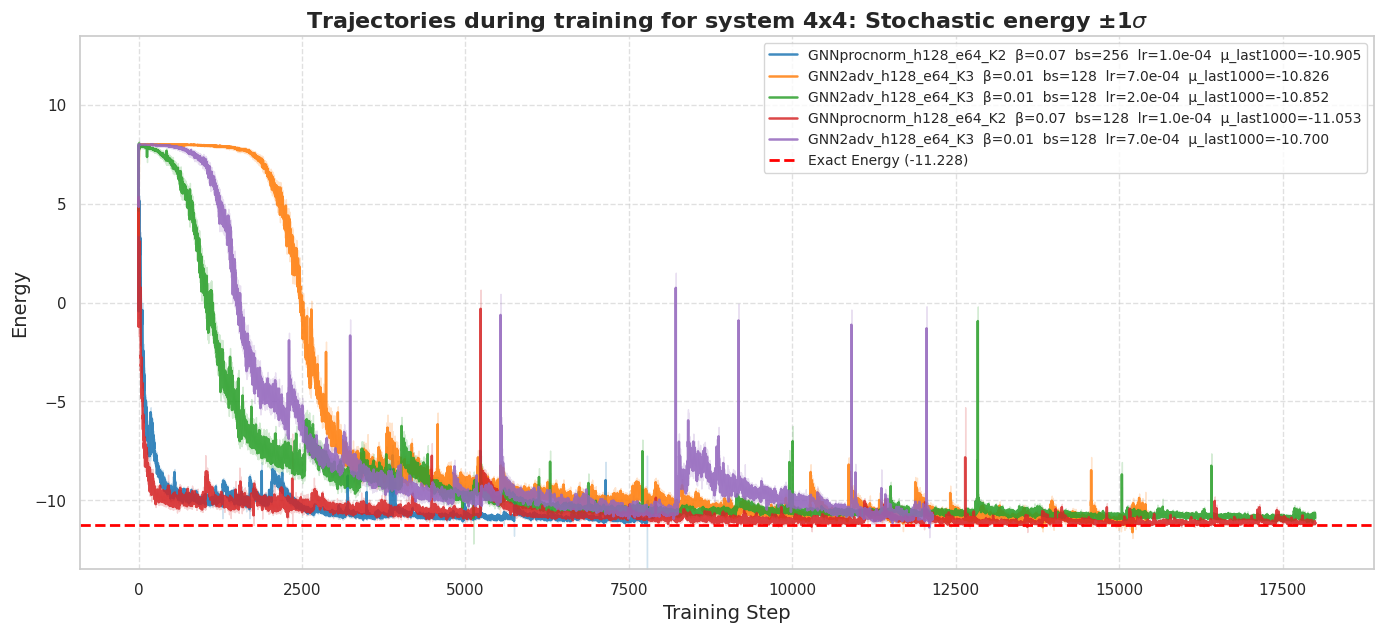

In [408]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


# Set seaborn style for prettier plots
sns.set_theme(style="whitegrid")

title_n=f"Trajectories during training for system {n}x{n}: Stochastic energy ±1" + r"$\sigma$"

plt.figure(figsize=(14, 12))

# calculate how far below exact_energy to clip
offset = 0.2 * abs(exact_energy)
ymin = exact_energy - offset

# get a categorical palette
palette = sns.color_palette("tab10", n_colors=len(runs_to_plot_df))

plt.figure(figsize=(14, 12))
ax1 = plt.subplot(2, 1, 1)

for (idx, run_data), color in zip(runs_to_plot_df.iterrows(), palette):
    steps       = np.array(run_data['steps'])
    energy      = np.array(run_data['training/energy_real'])
    std_energy  = np.array(run_data['training/std_energy'])
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # extract a simpler run name
    run_name   = run_data.get('run_name', str(idx))
    m          = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name= m.group(0) if m else run_name.split('/')[-1]

    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

# 3. exact energy line
ax1.axhline(y=exact_energy,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ({exact_energy:.3f})')

# 4. clip y-axis to 20% below the ground truth
ax1.set_ylim(bottom=ymin,top=-ymin)
ax1.set_title(title_n, fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [409]:
df_runs_seeded_copy_filtered_high_energy=df_runs_seeded_copy_filtered[df_runs_seeded_copy_filtered['final_energy'] >7]


<Figure size 1400x1200 with 0 Axes>

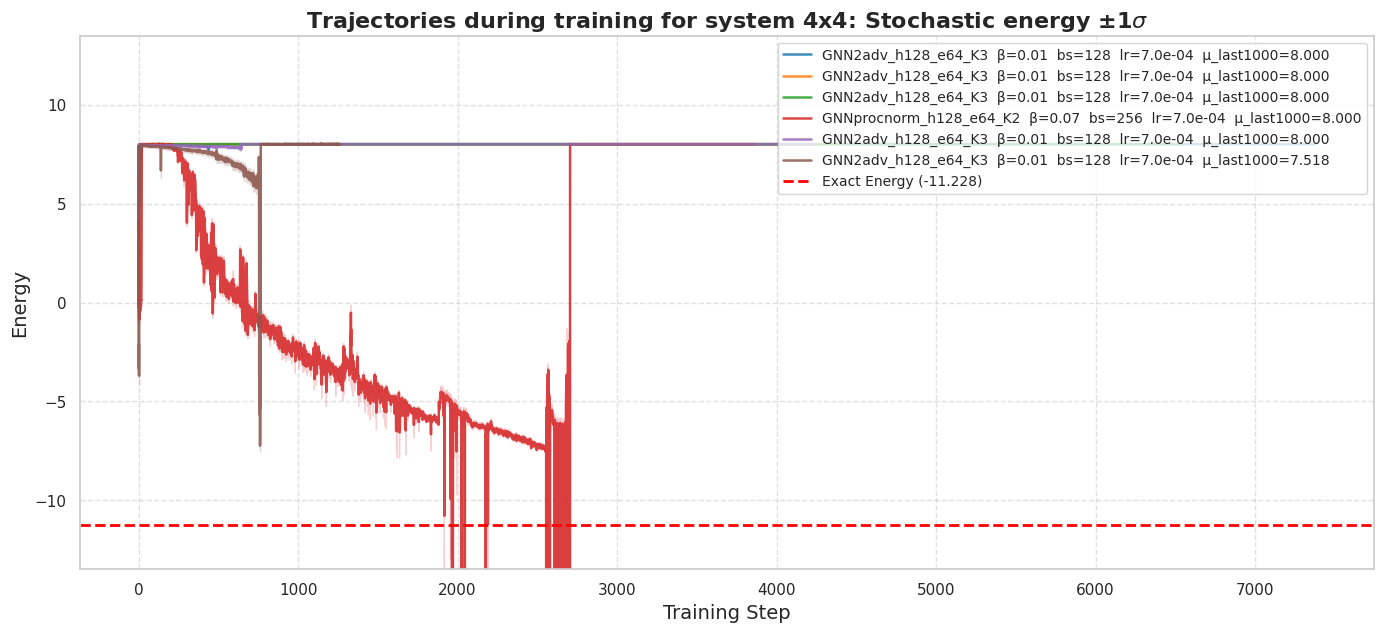

In [410]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


# Set seaborn style for prettier plots
sns.set_theme(style="whitegrid")

title_n=f"Trajectories during training for system {n}x{n}: Stochastic energy ±1" + r"$\sigma$"

plt.figure(figsize=(14, 12))

# calculate how far below exact_energy to clip
offset = 0.2 * abs(exact_energy)
ymin = exact_energy - offset

# get a categorical palette
palette = sns.color_palette("tab10", n_colors=len(df_runs_seeded_copy_filtered_high_energy))

plt.figure(figsize=(14, 12))
ax1 = plt.subplot(2, 1, 1)

for (idx, run_data), color in zip(df_runs_seeded_copy_filtered_high_energy.iterrows(), palette):
    steps       = np.array(run_data['steps'])
    energy      = np.array(run_data['training/energy_real'])
    std_energy  = np.array(run_data['training/std_energy'])
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # extract a simpler run name
    run_name   = run_data.get('run_name', str(idx))
    m          = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name= m.group(0) if m else run_name.split('/')[-1]

    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

# 3. exact energy line
ax1.axhline(y=exact_energy,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ({exact_energy:.3f})')

# 4. clip y-axis to 20% below the ground truth
ax1.set_ylim(bottom=ymin,top=-ymin)
ax1.set_title(title_n, fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [352]:
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
tf.get_logger().setLevel('ERROR')
models = {}
for idx, d in enumerate(dirs_lowE):
    ckpt_paths=sorted(glob.glob(d+'/checkpoints/*.index', recursive=True))
    ckpt_idxs = sorted(glob.glob(os.path.join(d, 'checkpoints', '*.index')))
    ckpt_path = ckpt_idxs[-2][:-6]   # rimuovo '.index'
    print("→ checkpoint:", ckpt_path)
    hyperparams=extract_hyperparams_from_path(ckpt_path)
    model_temp=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params,0)
    optimizer_temp=snt.optimizers.Adam(hyperparams.sim_params.learning_rate,0.9,0.99)
    # prova forward prima del caricamento
    _ = model_temp(GT_Batch_init)

    # carica pesi
    load_model_from_path(
        model=model_temp,
        checkpoint_path=ckpt_path,  # load_model cerca i file .index ecc qui
        optimizer=optimizer_temp
    )

    # verifica forward dopo
    psi_val = model_temp(GT_Batch_init)[0]
    print(f"✔ Caricato modello da {d}, psi_val[0]={psi_val}")

    # chiave unica: basename + beta + bs
    run_key = os.path.basename(d) +f"_b{hyperparams.sim_params.beta}_bs{hyperparams.sim_params.batch_size}_lr{hyperparams.sim_params.learning_rate}"+"_"+str(idx)
    models[run_key] = {
        "model": model_temp,
        "hyperparams": hyperparams
    }

print("\nModelli caricati:", list(models.keys()))

→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_256lr1.0e-04_loop1210x30_overlap_VMC/GNNprocnorm_h128_e64_K2/checkpoints/ckpt-8
✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_256lr1.0e-04_loop1210x30_overlap_VMC/GNNprocnorm_h128_e64_K2, psi_val[0]=[ 1.6109681 14.3383255]
→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1029x15_overlap_VMC/GNN2adv_h128_e64_K3/checkpoints/ckpt-34
✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1029x15_overlap_VMC/GNN2adv_h128_e64_K3, psi_val[0]=[-0.30416265 10.295447  ]
→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3/checkpoints/ckpt-39
✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h12

In [ ]:

# 2b) Build checkerboard ε_i = ±1
eps = np.array([1 if (x+y)%2==0 else -1
                for x in range(n) for y in range(m)])  # shape (16,)


In [370]:
# results = {}
rows=[]
for run_key, data in models.items():
    model = data["model"]
    hyperparams = data["hyperparams"]
    GT_batch_temp=initialize_graph_tuples_tf_opt(hyperparams.sim_params.batch_size, graph, sublattice_encoding=subl)

    print("model", run_key)
    print(model(GT_batch_temp)[82])  # Ensure model is initialized

    psi=model(GT_batch_temp)
    # 1) Initialize the graph
    initial_energy, std_initial,_ =stochastic_energy_tf(psi, model, edge_pairs, template_graphs_output,GT_Batch_update,0)
    print("Initial energy:", initial_energy, 'std',std_initial)
    sampler_var_temp=MCMCSampler(GT_batch_temp)
    thermalization=200*n_sites

    for i in range(thermalization):

        GT_batch_temp, psi=sampler_var_temp.monte_carlo_update_on_batch_profilemem(model,GT_batch_temp)
    energy_after_term, std_after_term,_ =stochastic_energy_tf(psi, model, edge_pairs, template_graphs_output,GT_batch_temp,0)

    print("Energy after:", energy_after_term, 'std',std_after_term)
    all_mrms = []
    all_mabs = []
    all_Spp  = []
    start_time=time.time()
    sampling=200*n_sites

    for step in range(sampling):
        for j in range(2*n_sites):
            GT_batch_temp, psi_new=sampler_var_temp.monte_carlo_update_on_batch_profilemem(model,GT_batch_temp)
        spins_flat = GT_batch_temp.nodes[:,0]                  
        spins_2d    = tf.reshape(spins_flat, (hyperparams.sim_params.batch_size, n_sites))    

        # 4) Compute staggered metrics
        m_rms, m_abs, S_pp = batch_staggered_metrics_pm1(spins_2d, eps)
        all_mrms.append(m_rms.numpy())
        all_mabs.append(m_abs.numpy())
        all_Spp.append(S_pp.numpy())
        rows.append({
            "run":      run_key,
            "step":     step,
            "m_rms":    float(m_rms.numpy()),
            "m_abs":    float(m_abs.numpy()),
            "S_pp":     float(S_pp.numpy())
        })        
    print("Tempo per campionamento:", time.time()-start_time)    
# Costruisco il DataFrame unico
df_traj = pd.DataFrame(rows)
print(df_traj.head())        

model GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0
tf.Tensor([10.291748  8.584942], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((-133.64711-134.5122j), shape=(), dtype=complex64) std tf.Tensor(2184.4314, shape=(), dtype=float32)
Energy after: tf.Tensor((-10.942918+0.025791315j), shape=(), dtype=complex64) std tf.Tensor(1.004171, shape=(), dtype=float32)
Tempo per campionamento: 1210.4528336524963
model GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_1
tf.Tensor([-0.3948756  8.55801  ], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((-302.41205+636.5458j), shape=(), dtype=complex64) std tf.Tensor(21637.08, shape=(), dtype=float32)
Energy after: tf.Tensor((-10.280878+0.18894906j), shape=(), dtype=complex64) std tf.Tensor(2.1065915, shape=(), dtype=float32)
Tempo per campionamento: 854.6764225959778
model GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0002_2
tf.Tensor([ 4.808653 11.628425], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((37.31107+139.85048j), shape=(), dtype=comple

In [374]:
df_traj[df_traj['step']==1500]

,run,step,m_rms,m_abs,S_pp
1500,GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0,1500,0.465090,0.376953,3.460938
4700,GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_1,1500,0.580548,0.508789,5.392578
7900,GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0002_2,1500,0.567792,0.485352,5.158203
11100,GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_3,1500,0.447022,0.372070,3.197266
14300,GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_4,1500,0.239272,0.190430,0.916016


In [377]:
df_traj_copy=df_traj[~df_traj['run'].str.contains("GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_4")]

In [383]:
df_traj_copy[df_traj_copy['step']==1500]

,run,step,m_rms,m_abs,S_pp
1500,GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0,1500,0.465090,0.376953,3.460938
4700,GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_1,1500,0.580548,0.508789,5.392578
7900,GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0002_2,1500,0.567792,0.485352,5.158203
11100,GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_3,1500,0.447022,0.372070,3.197266


In [ ]:
m_rms_quimb

0.6072090646153094

<Axes: xlabel='step', ylabel='m_rms'>

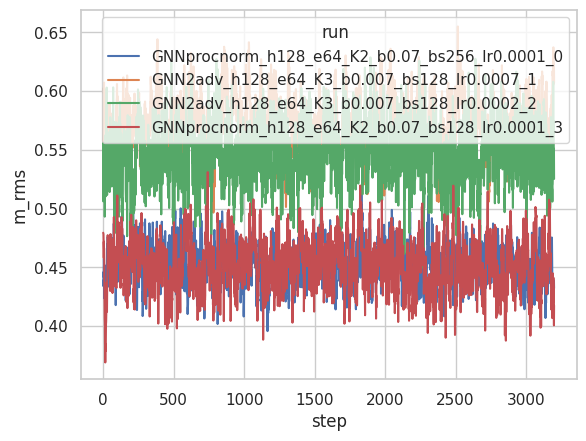

In [379]:
import seaborn as sns
sns.lineplot(data=df_traj_copy, x="step", y="m_rms", hue="run")

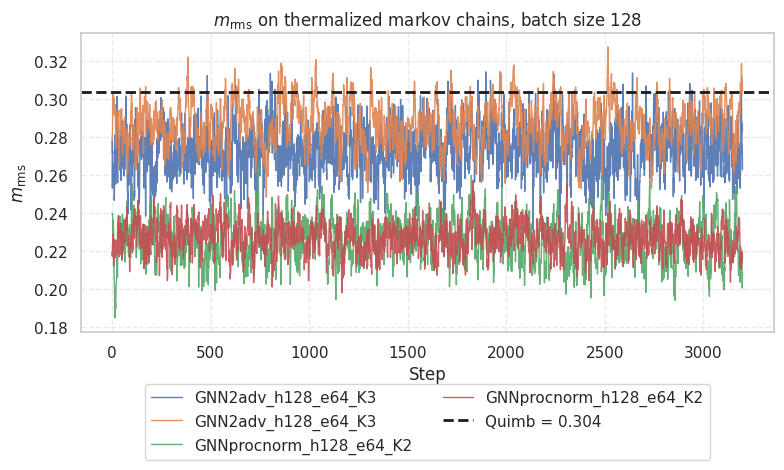

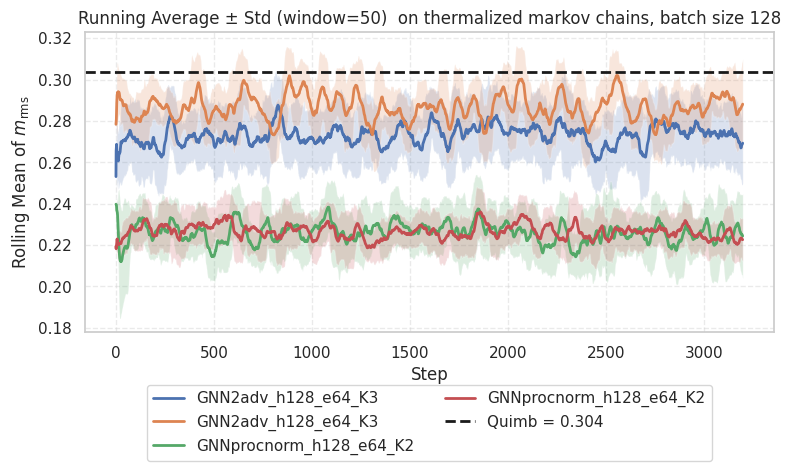

In [403]:
import pandas as pd
import matplotlib.pyplot as plt

def abbrevia(key):
    m = re.match(r'^(.*?K.).*(.)$', key)
    if m:
        return f"{m.group(1)}"
    else:
        return key[:10] + "…" + key[-1]
# 2) Plot raw trajectories con legenda esterna
# 4. Plot delle traiettorie
fig, ax = plt.subplots(figsize=(8, 5))
for run_key, df_run in df_traj_copy.groupby('run'):
    ax.plot(df_run['step'], df_run['m_rms']/2,
             alpha=0.9, linewidth=1, label=abbrevia(run_key))
    # 5. Linea orizzontale Quimb
ax.axhline(m_rms_quimb/2, color='k', linestyle='--', linewidth=2,
           label=f"Quimb = {m_rms_quimb/2:.3f}")
ax.set_xlabel('Step')
ax.set_ylabel(r'$m_\mathrm{rms}$')
ax.set_title('$m_{\\rm rms}$ on thermalized markov chains, batch size 128')
ax.grid(True, linestyle='--', alpha=0.4)
# Legenda sotto, 2 colonne (regola ncol in base al num. di run)
ax.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=2,
           frameon=True)

fig.tight_layout()
plt.show()

# 7. Plot rolling mean ± std (facoltativo)
window = 50
fig, ax = plt.subplots(figsize=(8, 5))
for run_key, df_run in df_traj_copy.groupby('run'):
    rm = df_run['m_rms'].rolling(window, min_periods=1).mean()/2
    rs = df_run['m_rms'].rolling(window, min_periods=1).std()/np.sqrt(2)

    ax.plot(df_run['step'], rm, linewidth=2, label=abbrevia(run_key))
    ax.fill_between(df_run['step'], rm - rs, rm + rs, alpha=0.2)

ax.axhline(m_rms_quimb/2, color='k', linestyle='--', linewidth=2,
           label=f"Quimb = {m_rms_quimb/2:.3f}")

ax.set_xlabel('Step')
ax.set_ylabel(r'Rolling Mean of $m_\mathrm{rms}$')
ax.set_title(f'Running Average ± Std (window={window})  on thermalized markov chains, batch size 128')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.15),
          ncol=2,
          frameon=True)
fig.tight_layout()
plt.show()

### Load unique model

In [358]:
filtered_dirs[-9]

'checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2'

In [331]:
import tensorflow as tf
import compgraph.tensorflow_version.model_loading
from compgraph.tensorflow_version.model_loading import check_and_reinitialize_model, load_model_from_path,extract_hyperparams_from_path
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
import sonnet as snt

# path_ckpt='checkpointed_logs/system_Heisenberg/2dsquare_05_05_Neel/beta0.1__bs_128lr7.0e-04_loop1024x15_overlap_VMC/GNN2adv_h128_e64_K3/checkpoints/initial_model-1'
hyperparams=extract_hyperparams_from_path(ckpt_path)
n_hyp,m_hyp=hyperparams.graph_params.n,hyperparams.graph_params.m
# n_hyp,m_hyp=6,6
graph,subl=create_graph_from_ham(hyperparams.graph_params.graphType,(n_hyp,m_hyp)
                                 ,sublattice=hyperparams.graph_params.sublattice)
graph_larger,subl_larger=create_graph_from_ham(hyperparams.graph_params.graphType,(n_hyp+2,m_hyp+2)
                                 ,sublattice=hyperparams.graph_params.sublattice)
GT_Batch_init=initialize_graph_tuples_tf_opt(128, graph, sublattice_encoding=subl)
GT_Batch_init_larger=initialize_graph_tuples_tf_opt(128, graph_larger, sublattice_encoding=subl_larger)
model_w_from_training=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params,0)
optimizer=snt.optimizers.Adam(hyperparams.sim_params.learning_rate,0.9,0.99)
before_loading=model_w_from_training(GT_Batch_init)[0]
load_model_from_path(model=model_w_from_training, checkpoint_path=ckpt_path[:-6], optimizer=optimizer)
model_w_from_training(GT_Batch_init)[0], before_loading

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.6109641, 14.3383255], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.58344996, -0.9999976 ], dtype=float32)>)

In [353]:
from compgraph.monte_carlo import MCMCSampler, compute_phi_terms
import tensorflow as tf
import time
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
model_fix=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)
model_fix(GT_Batch_init)
sen, rec, edge_pairs=precompute_graph_structure(graph)
GT_Batch_update=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
sampler_var= MCMCSampler(GT_Batch_update)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)

sampler_te=MCMCSampler(GT_Batch_update, template_graphs_output,beta=0.07, edge_pairs=edge_pairs)
energy_real=[]
energy_imag=[]
std_energies=[]
magnetization=[]
grad_norms=[]
n_sites=n_hyp*m_hyp
psi=model_w_from_training(GT_Batch_update)
initial_energy, std_initial,_ =stochastic_energy_tf(psi, model_w_from_training, edge_pairs, template_graphs_output,GT_Batch_update,0)


In [354]:
initial_energy, std_initial

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-7.7664094+0.8209515j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.631698>)

In [ ]:
thermalization=100*n_sites

for i in range(thermalization):

    GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch_profilemem(model_w_from_training,GT_Batch_update)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [264]:
# 2b) Build checkerboard ε_i = ±1
eps_6x6 = np.array([1 if (x+y)%2==0 else -1
                for x in range(n_hyp) for y in range(m_hyp)])  # shape (16,)

In [265]:
sampling=100*n_sites

for i in range(sampling):
    for j in range(2*n_sites):
        GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch_profilemem(model_w_from_training,GT_Batch_update)
    spins_flat = GT_Batch_update.nodes[:,0]                  
    spins_2d    = tf.reshape(spins_flat, (hyperparams.sim_params.batch_size, n_sites))    

    # 4) Compute staggered metrics
    m_rms, m_abs, S_pp = batch_staggered_metrics_pm1(spins_2d, eps_6x6)
    print(i,m_rms, m_abs, S_pp)

0 tf.Tensor(0.20441924, shape=(), dtype=float32) tf.Tensor(0.15668403, shape=(), dtype=float32) tf.Tensor(1.5043403, shape=(), dtype=float32)
1 tf.Tensor(0.21109283, shape=(), dtype=float32) tf.Tensor(0.17447917, shape=(), dtype=float32) tf.Tensor(1.6041666, shape=(), dtype=float32)
2 tf.Tensor(0.20606403, shape=(), dtype=float32) tf.Tensor(0.1610243, shape=(), dtype=float32) tf.Tensor(1.5286459, shape=(), dtype=float32)
3 tf.Tensor(0.19357444, shape=(), dtype=float32) tf.Tensor(0.15364583, shape=(), dtype=float32) tf.Tensor(1.3489584, shape=(), dtype=float32)
4 tf.Tensor(0.19928257, shape=(), dtype=float32) tf.Tensor(0.15668403, shape=(), dtype=float32) tf.Tensor(1.4296875, shape=(), dtype=float32)
5 tf.Tensor(0.21855702, shape=(), dtype=float32) tf.Tensor(0.17144097, shape=(), dtype=float32) tf.Tensor(1.7196181, shape=(), dtype=float32)
6 tf.Tensor(0.21000487, shape=(), dtype=float32) tf.Tensor(0.17057292, shape=(), dtype=float32) tf.Tensor(1.5876737, shape=(), dtype=float32)
7 tf.Te

KeyboardInterrupt: 

In [413]:
psi_new=model_w_from_training(GT_Batch_update)
energy_after_term, std_initial_term,_ =stochastic_energy_tf(psi_new, model_w_from_training, edge_pairs, template_graphs_output,GT_Batch_update,0)
energy_after_term, std_initial_term

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-10.860567+0.014412865j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.96852887>)

In [420]:
graph_larger,subl_larger=create_graph_from_ham(hyperparams.graph_params.graphType,(n_hyp+2,m_hyp+2)
                                 ,sublattice=hyperparams.graph_params.sublattice)
GT_Batch_update_larger=initialize_graph_tuples_tf_opt(128, graph_larger, sublattice_encoding=subl_larger)
_,_, edge_pairs_larger=precompute_graph_structure(graph_larger)
template_graphs_output_larger=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs_larger)[0]+1, graph_larger, sublattice_encoding=subl_larger)

In [428]:
psi_new=model_w_from_training(GT_Batch_update_larger)


energy_after_term, std_initial_term,_ =stochastic_energy_tf(psi_new, model_w_from_training, edge_pairs_larger, template_graphs_output_larger,GT_Batch_update_larger,0)
energy_after_term, std_initial_term

W0000 00:00:1745825715.646595 3113084 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1745825720.999738 1092911 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(<tf.Tensor: shape=(), dtype=complex64, numpy=(-30.866627-55.119324j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=668.77057>)

In [ ]:
thermalization=100*36

for i in range(thermalization):

    GT_Batch_update_larger, psi_new=sampler_var.monte_carlo_update_on_batch_profilemem(model_w_from_training,GT_Batch_update_larger)
    print(i, psi_new[0])


NameError: name 'sampler_var' is not defined

In [66]:
GT_Batch_update_sym=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl,sz_sector=8)
thermalization=100*n_sites

for i in range(thermalization):

    GT_Batch_update_sym, psi_new=sampler_var.monte_carlo_update_on_batchv2(model_w_from_training,GT_Batch_update_sym)

### Compute energy and magnetization quantities in MC sampling

In [58]:
GT_Batch_update_single=initialize_graph_tuples_tf_opt(1,graph, sublattice_encoding=subl)
for i in range(thermalization*10):
    GT_Batch_update_single, psi_new=sampler_var.monte_carlo_update_on_batch_profilemem(model_w_from_training,GT_Batch_update_single)

In [ ]:
energy_real_sym=[]
energy_imag_sym=[]
std_energies_sym=[]
magnetization_sym=[]
m_rms_sym=[]
m_abs_sym=[]
Spp_sym=[]

for i in range(600):
    for j in range(16):
        GT_Batch_update_sym, psi_new=sampler_var.monte_carlo_update_on_batchv2(model_w_from_training,GT_Batch_update_sym)
    # final_energy_one_sample, final_std, loc_final=stochastic_energy_tf(psi_new, model_w_from_training, edge_pairs, template_graphs_output,GT_Batch_update_sym,0)
    spins_flat = GT_Batch_update_sym.nodes[:,0]                         # shape (batch_size * n_sites,)
    spins_2d    = tf.reshape(spins_flat, (hyperparams.sim_params.batch_size, n_sites))     # (batch_size, n_sites)

    # 4) Compute staggered metrics
    m_rms, m_abs, S_pp = batch_staggered_metrics_pm1(spins_2d, eps)
    # print(f"Step {i:3d}  E = {final_energy_one_sample:.4f} ± {final_std:.4f}  "
    #       f"m_rms = {m_rms:.4f}, m_abs = {m_abs:.4f}, S(π,π) = {S_pp:.4f}")
    # energy_real_sym.append(tf.math.real(final_energy_one_sample))
    # energy_imag_sym.append(final_std)
    # std_energies_sym.append(final_std)
    m_rms_sym.append(m_rms)
    m_abs_sym.append(m_abs)
    Spp_sym.append(S_pp)

Step   0  E = -10.9803-0.0063j ± 2.4148  m_rms = 0.6412, m_abs = 0.5625, S(π,π) = 6.5781
Step   1  E = -10.9562+0.1126j ± 2.4240  m_rms = 0.6416, m_abs = 0.5645, S(π,π) = 6.5859
Step   2  E = -10.8305+0.1219j ± 2.3668  m_rms = 0.6450, m_abs = 0.5703, S(π,π) = 6.6562
Step   3  E = -10.7383+0.1245j ± 2.1166  m_rms = 0.6401, m_abs = 0.5684, S(π,π) = 6.5547
Step   4  E = -10.7352+0.1387j ± 2.1360  m_rms = 0.6397, m_abs = 0.5703, S(π,π) = 6.5469
Step   5  E = -10.7520+0.2267j ± 2.1445  m_rms = 0.6366, m_abs = 0.5703, S(π,π) = 6.4844
Step   6  E = -10.7339+0.1671j ± 2.0588  m_rms = 0.6358, m_abs = 0.5703, S(π,π) = 6.4688
Step   7  E = -10.7171+0.0855j ± 2.1317  m_rms = 0.6277, m_abs = 0.5605, S(π,π) = 6.3047
Step   8  E = -10.7720+0.0567j ± 2.1249  m_rms = 0.6316, m_abs = 0.5605, S(π,π) = 6.3828
Step   9  E = -10.7022-0.0081j ± 2.1272  m_rms = 0.6273, m_abs = 0.5586, S(π,π) = 6.2969
Step  10  E = -10.7300-0.0328j ± 2.0678  m_rms = 0.6242, m_abs = 0.5547, S(π,π) = 6.2344
Step  11  E = -10.617

In [59]:
energy_real=[]
energy_imag=[]
std_energies=[]
m_rms_list=[]
m_abs_list=[]
stag_squared_list=[]

In [60]:
for i in range(8000):
    for j in range(1):
       GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch_profilemem(model_w_from_training,GT_Batch_update)           
    final_energy_one_sample, final_std, loc_final=stochastic_energy_tf(psi_new, model_w_from_training, edge_pairs, template_graphs_output,GT_Batch_update,0)
    spins_flat = GT_Batch_update.nodes[:,0]                  
    spins_2d    = tf.reshape(spins_flat, (hyperparams.sim_params.batch_size, n_sites))    

    # 4) Compute staggered metrics
    m_rms, m_abs, S_pp = batch_staggered_metrics_pm1(spins_2d, eps)
    print(f"Step {i:3d}  E = {final_energy_one_sample:.4f} ± {final_std:.4f}  "
          f"m_rms = {m_rms:.4f}, m_abs = {m_abs:.4f}, S(π,π) = {S_pp:.4f}")
    energy_real.append(tf.math.real(final_energy_one_sample))
    energy_imag.append(final_std)
    std_energies.append(final_std)
    m_rms_list.append(m_rms)
    m_abs_list.append(m_abs)
    stag_squared_list.append(S_pp)

Step   0  E = -11.0409+0.0057j ± 0.6929  m_rms = 0.4773, m_abs = 0.3965, S(π,π) = 3.6445
Step   1  E = -11.0038-0.0128j ± 0.7294  m_rms = 0.4747, m_abs = 0.3906, S(π,π) = 3.6055
Step   2  E = -11.0031-0.0281j ± 0.7401  m_rms = 0.4744, m_abs = 0.3926, S(π,π) = 3.6016
Step   3  E = -11.0002-0.0272j ± 0.7340  m_rms = 0.4723, m_abs = 0.3916, S(π,π) = 3.5684
Step   4  E = -11.0059-0.0384j ± 0.7677  m_rms = 0.4730, m_abs = 0.3916, S(π,π) = 3.5801
Step   5  E = -11.0469-0.0243j ± 0.7575  m_rms = 0.4775, m_abs = 0.3945, S(π,π) = 3.6484
Step   6  E = -10.9834-0.0211j ± 0.8069  m_rms = 0.4764, m_abs = 0.3916, S(π,π) = 3.6309
Step   7  E = -11.0253-0.0173j ± 0.7587  m_rms = 0.4726, m_abs = 0.3906, S(π,π) = 3.5742
Step   8  E = -10.9786+0.0101j ± 0.7970  m_rms = 0.4711, m_abs = 0.3867, S(π,π) = 3.5508
Step   9  E = -10.9738-0.0049j ± 0.7970  m_rms = 0.4695, m_abs = 0.3848, S(π,π) = 3.5273
Step  10  E = -11.0158-0.0080j ± 0.7385  m_rms = 0.4690, m_abs = 0.3848, S(π,π) = 3.5195
Step  11  E = -11.023

## Magnetization histogram

Step    0  E = -10.6857-0.1721j ± 2.5366   m_rms = 0.4713,  m_abs = 0.3926,  S(π,π) = 3.5547
Step    1  E = -10.9325-0.0509j ± 2.8991   m_rms = 0.4707,  m_abs = 0.3936,  S(π,π) = 3.5449
Step    2  E = -10.9313-0.0901j ± 2.9836   m_rms = 0.4710,  m_abs = 0.3936,  S(π,π) = 3.5488
Step    3  E = -10.8459-0.1203j ± 2.9035   m_rms = 0.4746,  m_abs = 0.3975,  S(π,π) = 3.6035
Step    4  E = -10.7420-0.1341j ± 3.1606   m_rms = 0.4757,  m_abs = 0.3965,  S(π,π) = 3.6211
Step    5  E = -10.8618-0.1303j ± 2.8356   m_rms = 0.4787,  m_abs = 0.3994,  S(π,π) = 3.6660
Step    6  E = -10.8663-0.1336j ± 2.4722   m_rms = 0.4744,  m_abs = 0.3945,  S(π,π) = 3.6016
Step    7  E = -10.7159-0.1691j ± 2.7012   m_rms = 0.4779,  m_abs = 0.3975,  S(π,π) = 3.6543
Step    8  E = -10.9135-0.1806j ± 2.5346   m_rms = 0.4764,  m_abs = 0.3975,  S(π,π) = 3.6309
Step    9  E = -10.7045-0.1523j ± 2.3700   m_rms = 0.4752,  m_abs = 0.3965,  S(π,π) = 3.6133
Step   10  E = -10.5854-0.1561j ± 2.3364   m_rms = 0.4757,  m_abs = 0.

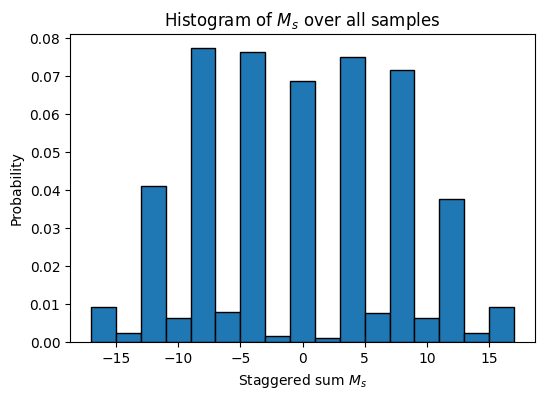

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- before the loop: parameters and storage ---
p_global = 0.01       # 1% chance per step of a global flip
Ms_values = []        # will collect every sample's Ms

# pre-compute eps as float32
eps = tf.constant(eps, dtype=tf.float32)  # shape (n_sites,)

for i in range(2000):
    # — do your local Monte Carlo updates —
    for _ in range(1):
        GT_Batch_update, psi_new = sampler_var.monte_carlo_update_on_batch(
            model_w_from_training, GT_Batch_update
        )

    # — occasionally do a global flip —
    if np.random.rand() < p_global:
        # flip the sign of the first node-feature (the spin) for every site
        nodes = GT_Batch_update.nodes  # shape (batch_size*n_sites, feature_dim)
        s = nodes[:, 0]                # all spins flattened
        # build a new nodes tensor with flipped spins
        new_nodes = tf.concat([
            tf.reshape(-s, (-1,1)),   # flip sign
            nodes[:, 1:],              # keep other features
        ], axis=1)
        # replace in the GraphTuple
        GT_Batch_update = GT_Batch_update._replace(nodes=new_nodes)
        # no need to re-compute psi_new: |ψ(-s)|² = |ψ(s)|²

    # — energy estimate —
    final_energy_one_sample, final_std, loc_final = stochastic_energy_tf(
        psi_new, model_w_from_training,
        edge_pairs, template_graphs_output,
        GT_Batch_update, 0
    )
    energy_real.append(float(tf.math.real(final_energy_one_sample).numpy()))
    std_energies.append(float(final_std.numpy()))

    # — extract spins & compute Ms for every chain in the batch —
    spins_flat = GT_Batch_update.nodes[:, 0]                   # (B*n_sites,)
    spins_2d   = tf.reshape(spins_flat, (hyperparams.sim_params.batch_size, n_sites))  # (B,N)
    Ms_batch   = tf.reduce_sum(spins_2d * eps[None, :], axis=1) # (B,)

    # — collect for histogram & error-analysis —
    Ms_values.extend(Ms_batch.numpy().tolist())

    # — compute and log your usual metrics —
    m_rms, m_abs, S_pp = batch_staggered_metrics_pm1(spins_2d, eps.numpy())
    m_rms_list.append(float(m_rms.numpy()))
    m_abs_list.append(float(m_abs.numpy()))
    stag_squared_list.append(float(S_pp.numpy()))

    print(f"Step {i:4d}  E = {final_energy_one_sample:.4f} ± {final_std:.4f}"
          f"   m_rms = {m_rms:.4f},  m_abs = {m_abs:.4f},  S(π,π) = {S_pp:.4f}")

# --- after the loop: plot Ms histogram ---

Ms_arr = np.array(Ms_values)
counts, bins = np.histogram(Ms_arr, bins=np.arange(-n_sites-1, n_sites+2, 2), density=True)

plt.figure(figsize=(6,4))
plt.bar(bins[:-1], counts, width=2, align='edge', edgecolor='k')
plt.xlabel("Staggered sum $M_s$")
plt.ylabel("Probability")
plt.title("Histogram of $M_s$ over all samples")
plt.show()


## Autocorrelation computation

In [61]:
def integrated_autocorr_time(X, max_lag=None):
    X = np.asarray(X, float)
    N = len(X)
    X -= X.mean()
    var = np.dot(X,X)
    if max_lag is None:
        max_lag = N//2
    rho = np.array([np.dot(X[:N-t], X[t:]) / var for t in range(max_lag)])
    # window at first zero-crossing
    pos = np.where(rho<0)[0]
    t_cut = pos[0] if len(pos)>0 else max_lag
    return 0.5 + rho[1:t_cut].sum()

# compute for batch‐mean series
tau_m_rms = integrated_autocorr_time(np.array(m_rms_list))
tau_m_abs = integrated_autocorr_time(np.array(m_abs_list))
tau_Spp   = integrated_autocorr_time(np.array(stag_squared_list))
tau_energy = integrated_autocorr_time(np.array(energy_real))
print("tau(m_rms) =", tau_m_rms)
print("tau(m_abs) =", tau_m_abs)
print("tau(S_pp)  =", tau_Spp)
print("tau(energy) =", tau_energy)

tau(m_rms) = 142.02737531021734
tau(m_abs) = 137.30584178990108
tau(S_pp)  = 139.86494977607362
tau(energy) = 46.51110588208491


### autocorrelation

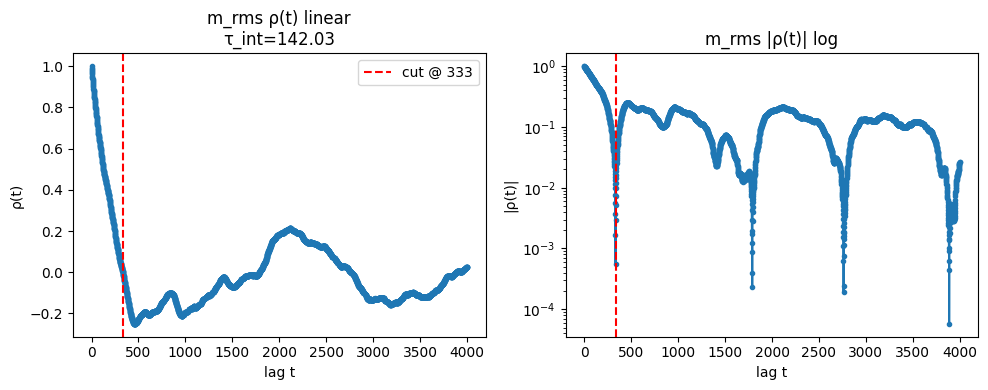

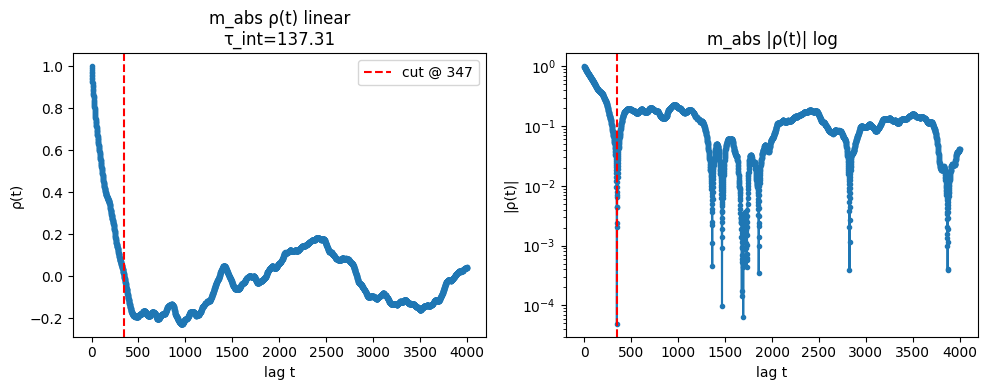

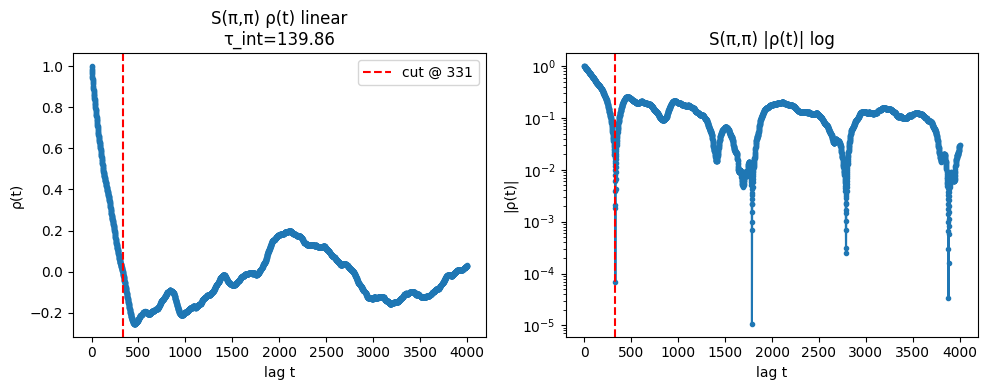

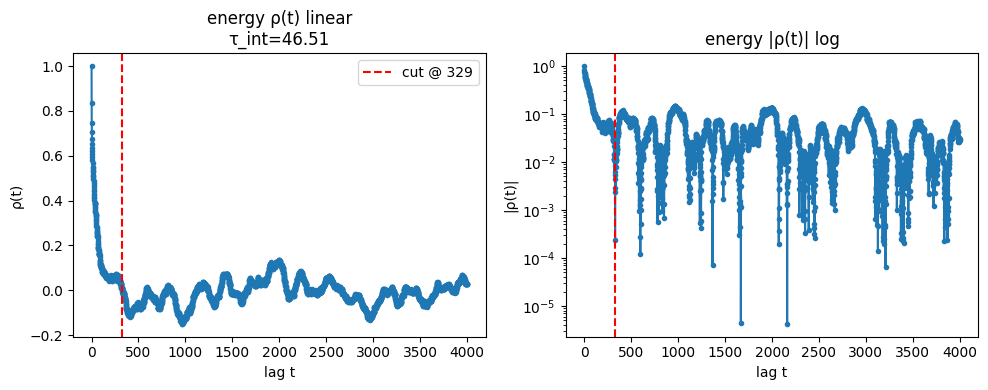

Results:
  τ(m_rms) = 142.02737531021734
  τ(m_abs) = 137.30584178990108
  τ(S_pp)  = 139.86494977607362
  τ(energy)= 46.51110588208491


In [62]:
import numpy as np
import matplotlib.pyplot as plt

def integrated_autocorr_time(X, max_lag=None, do_plot=True, title=""):
    """
    Estimate the integrated autocorrelation time τ_int of 1D array X,
    *and* plot ρ(t) if do_plot=True.

    Returns:
        tau_int, rho   # tau and the full autocorrelation array
    """
    X = np.asarray(X, float)
    N = len(X)
    X -= X.mean()
    var = np.dot(X, X)

    if max_lag is None:
        max_lag = N // 2

    # compute autocorrelation ρ(t)
    rho = np.empty(max_lag)
    for t in range(max_lag):
        rho[t] = np.dot(X[:N-t], X[t:]) / var

    # find first zero crossing
    pos = np.where(rho < 0)[0]
    t_cut = pos[0] if len(pos)>0 else max_lag

    # integrated autocorrelation time
    tau_int = 0.5 + rho[1:t_cut].sum()

    if do_plot:
        lags = np.arange(max_lag)
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
        ax1.plot(lags, rho, '.-')
        ax1.axvline(t_cut, color='red', linestyle='--',
                    label=f"cut @ {t_cut}")
        ax1.set_title(f"{title} ρ(t) linear\nτ_int={tau_int:.2f}")
        ax1.set_xlabel("lag t")
        ax1.set_ylabel("ρ(t)")
        ax1.legend()

        ax2.semilogy(lags, np.abs(rho), '.-')
        ax2.axvline(t_cut, color='red', linestyle='--')
        ax2.set_title(f"{title} |ρ(t)| log")
        ax2.set_xlabel("lag t")
        ax2.set_ylabel("|ρ(t)|")

        plt.tight_layout()
        plt.show()

    return tau_int, rho

# --- now call it on your four series ---

tau_m_rms,   rho_rms   = integrated_autocorr_time(
    m_rms_list,   title="m_rms"
)
tau_m_abs,   rho_abs   = integrated_autocorr_time(
    m_abs_list,   title="m_abs"
)
tau_Spp,     rho_Spp   = integrated_autocorr_time(
    stag_squared_list, title="S(π,π)"
)
tau_energy,  rho_energy= integrated_autocorr_time(
    energy_real,  title="energy"
)

print("Results:")
print("  τ(m_rms) =", tau_m_rms)
print("  τ(m_abs) =", tau_m_abs)
print("  τ(S_pp)  =", tau_Spp)
print("  τ(energy)=", tau_energy)


In [146]:
import numpy as np

def integrated_autocorr_time(X, c=5, burn_fraction=0.2, max_lag=None, tol=1e-3):
    """
    Estimate the integrated autocorrelation time τ_int of a 1D series X.
    - Discards the first burn_fraction of samples.
    - Uses self-consistent window M = min(max_lag, c * τ_prev).
    - Iterates until τ converges within tol.
    """
    X = np.asarray(X, float)
    N = len(X)
    # 1) burn-in removal
    burn = int(burn_fraction * N)
    if burn >= N//2:
        raise ValueError("burn_fraction too large for series length")
    X = X[burn:]
    N2 = len(X)

    # center and variance
    X -= X.mean()
    var = np.dot(X, X)

    # maximum lag to consider
    if max_lag is None:
        max_lag = N2 // 2

    # precompute autocorrelation up to max_lag
    rho = np.empty(max_lag)
    for t in range(max_lag):
        rho[t] = np.dot(X[:N2-t], X[t:]) / var

    # 2) self-consistent iteration
    tau = 1.0  # initial guess
    for _ in range(50):
        M = min(int(c * tau), max_lag - 1)
        tau_new = 0.5 + rho[1:M+1].sum()
        if abs(tau_new - tau) < tol:
            tau = tau_new
            print("Warning: τ_int did converge (last change = ",)

            break
        tau = tau_new
    else:
        # no convergence warning
        print("Warning: τ_int did not fully converge (last change = ",
              tau_new - tau, ")")

    return tau, rho

# Example usage:
# assume m_rms_list is your list of batch‐mean m_rms values
tau_m_rms   = integrated_autocorr_time(m_rms_list,   c=5, burn_fraction=0.1)
tau_m_abs   = integrated_autocorr_time(m_abs_list,   c=5, burn_fraction=0.1)
tau_Spp     = integrated_autocorr_time(stag_squared_list, c=5, burn_fraction=0.1)
tau_energy  = integrated_autocorr_time(energy_real,  c=5, burn_fraction=0.1)

print("τ(m_rms) =", tau_m_rms)
print("τ(m_abs) =", tau_m_abs)
print("τ(S_pp)  =", tau_Spp)
print("τ(energy)=", tau_energy)


τ(m_rms) = (190.40229822953864, array([1.        , 0.99383225, 0.98635935, ..., 0.02893018, 0.02887192,
       0.028675  ]))
τ(m_abs) = (220.65707132817306, array([1.        , 0.99487119, 0.98823818, ..., 0.03016024, 0.02994465,
       0.02959301]))
τ(S_pp)  = (187.15088302643338, array([1.        , 0.99386164, 0.98653978, ..., 0.02473216, 0.02470868,
       0.02455043]))
τ(energy)= (0.5675962064595349, array([ 1.00000000e+00,  3.55793925e-02,  3.20168140e-02, ...,
       -5.86700913e-03, -1.98069826e-05, -9.68123419e-04]))


## End of Autocorrelation computation

In [65]:
ge=qu.groundenergy(H)

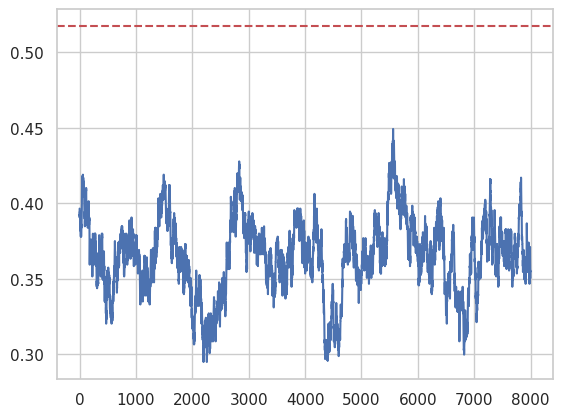

In [303]:
import matplotlib.pyplot as plt
plt.axhline(y=m_abs_quimb, color='r', linestyle='--', label='Exact m_rms')
plt.plot(m_abs_list)

In [ ]:
n_samples=6000
autocorr=n_sites
energy_real=[]
energy_imag=[]
std_energies=[]
magnetization=[]
stagg_magnet=[]

for sample in range(0,n_samples):

    for i in range(autocorr):

        GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch(model_w_from_training,GT_Batch_update)
    energy, std_energy, loc_energies = stochastic_energy_tf(psi_new, model_w_from_training, edge_pairs, template_graphs_output,GT_Batch_update)
    energy_real.append(tf.math.real(energy))
    energy_imag.append(tf.math.imag(energy))
    std_energies.append(std_energy)
    
    spins=GT_Batch_update


In [304]:
final_energy_one_sample, final_std

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-10.995794+0.0074543925j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6236802>)

# Quimb AFM Gs

In [16]:
def _build_Sz_ops(n, m):
    """Return list of Sz operators for each site (flattened index i↔(x,y))."""
    dims = [[2]*m]*n
    Sz = qu.spin_operator('z', sparse=True)
    ops = []
    for x in range(n):
        for y in range(m):
            ops.append(qu.ikron(Sz, dims, inds=[(x,y)]))
    return ops
def _sign_pattern(n, m):
    """
    Flattened array ε_i = (–1)^(x+y).
    This only holdes if we consider even number of sites
    where we can apply the Marshall sign rule, for odd number of sites
    or geometrically different lattices we can not measure the AFM state like this anymore
    """
    eps = np.zeros(n*m, dtype=int)
    for x in range(n):
        for y in range(m):
            eps[x*m + y] = 1 if (x+y)%2==0 else -1
    return eps

In [17]:
Sz_ops=_build_Sz_ops(n, m)
sign_pattern=_sign_pattern(n, m)


In [ ]:
import numpy as np, quimb as qu

def staggered_operators(n, m):
    """Return epsilon-array and staggered operator Ms."""
    dims = [[2]*m]*n
    Sz   = qu.spin_operator('z', sparse=True)
    eps  = np.array([ 1 if (x+y)%2==0 else -1
                      for x in range(n) for y in range(m)])
    Ms   = sum(eps[i] * qu.ikron(Sz, dims, inds=[divmod(i,m)])
               for i in range(n*m))
    return eps, Ms

def staggered_measures(psi, n, m, return_full=False):
    """m_s,rms , m_s,abs , structure factor  S(pi,pi)."""
    eps, Ms = staggered_operators(n, m)
    m_i=_build_Sz_ops(n, m)
    M_tot=sum(m_i[i] for i in range(n*m))
    magnetization= qu.expec(M_tot, psi)
    N   = n*m
    Ms2 = qu.expec(Ms@Ms, psi)
    m_rms = np.sqrt(Ms2)/N
    # absolute value ⟨|Ms|⟩ : brute-force sum over basis for small N
    dims = [[2]*m]*n
    basis_sz = 2**N
    if N <= 20:                         # exact enumeration still cheap
        basis = (np.arange(basis_sz)[:,None] >> np.arange(N)) & 1
        basis = basis*2 - 1             # ±1 spins
        probs = np.abs(psi)**2
        Ms_vals = (eps[None,:] * basis).sum(axis=1)
        m_abs = np.dot(probs.flatten(), np.abs(Ms_vals)) / N
    else:                               # need MC sampling
        m_abs = None
    Spp = Ms2 / N
    if return_full:
        return dict(m_rms=m_rms, m_abs=m_abs, Spp=Spp,
                    Ms2=Ms2, Ms_op=Ms)
    return m_rms, m_abs, Spp, magnetization

# n×m demo ------------------------------------------------------------
import quimb as qu
n,m=4,4
bz=0
hamiltonian=qu.ham_heis_2D(n,m,1, bz,True)
gs=qu.groundstate(hamiltonian)
m_rms, m_abs, Spp, magn = staggered_measures(gs,n,m)
print(f"{n}×{m} singlet  →  ⟨Ms⟩={magn}  but")
print(f"  m_s,rms  = {m_rms:.4f}")
print(f"  m_s,abs  = {m_abs:.4f}")
print(f"  S(π,π)   = {Spp:.4f}")


4×4 singlet  →  ⟨Ms⟩=-1.141781048846997e-28  but
  m_s,rms  = 0.3036
  m_s,abs  = 0.5174
  S(π,π)   = 1.4748


In [288]:
3*Spp/n/m, S2[0, 0]

(0.27652713611324775, 0.27652713611324775)

In [ ]:
import numpy as np
import quimb as qu

# ------------------------------------------------------------------
# 1. single–site spin-½ operators (sparse keeps memory low)
Sx = qu.spin_operator('x', sparse=True)
Sy = qu.spin_operator('y', sparse=True)
Sz = qu.spin_operator('z', sparse=True)

# ------------------------------------------------------------------
def _site_op(op, i, N):
    """Return operator `op` acting on site i (0 … N-1)."""
    return qu.ikron(op, dims=[2]*N, inds=[i])

def build_site_ops(n, m):
    """Pre-build {Sx_i, Sy_i, Sz_i} for every site to avoid repetition."""
    N   = n*m
    Sxs = [_site_op(Sx, i, N) for i in range(N)]
    Sys = [_site_op(Sy, i, N) for i in range(N)]
    Szs = [_site_op(Sz, i, N) for i in range(N)]
    return Sxs, Sys, Szs

# ------------------------------------------------------------------
def spin_structure_factor(psi, n, m, kxs=None, kys=None):
    """
    Return S²(kx,ky) on the mesh (len(kxs), len(kys)).
    """
    N      = n*m
    Sxs, Sys, Szs = build_site_ops(n, m)          # cache single-site ops
    coords = np.array([(i//m, i % m) for i in range(N)])

    # two-site correlator C_{ij} = Σ_α <S_i^α S_j^α>
    C = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(N):
            C[i, j] = (
                qu.expec(Sxs[i] @ Sxs[j], psi)
              + qu.expec(Sys[i] @ Sys[j], psi)
              + qu.expec(Szs[i] @ Szs[j], psi)
            )

    # default k-grid covers the Brillouin zone
    if kxs is None:
        kxs = np.linspace(-np.pi, np.pi, n, endpoint=False)
    if kys is None:
        kys = np.linspace(-np.pi, np.pi, m, endpoint=False)

    S2 = np.empty((len(kxs), len(kys)), dtype=float)
    for ix, kx in enumerate(kxs):
        for iy, ky in enumerate(kys):
            phase = np.exp(1j * (kx*(coords[:,0,None]-coords[:,0])
                               + ky*(coords[:,1,None]-coords[:,1])))
            S2[ix, iy] = (C * phase).sum().real / N**2
    return kxs, kys, S2


Ham_3x3=qu.ham_heis_2D(3,3,1,0.0,True)
gs_3x3=qu.groundstate(Ham_3x3)
# structure factor
kx, ky, S2 = spin_structure_factor(gs_3x3, 3,3)

# value at (π,π)
ix = np.argmin(np.abs(kx - np.pi))
iy = np.argmin(np.abs(ky - np.pi))
print(f"S²(π,π) = {S2[ix, iy]:.4f}")


S²(π,π) = 0.0514


In [300]:
# build a k–grid in [−π, π)
kxs = np.linspace(-np.pi, np.pi, n, endpoint=False)
kys = np.linspace(-np.pi, np.pi, m, endpoint=False)
kx, ky, S2 = spin_structure_factor(gs, n, m, kxs, kys)

# find index whose k is closest to +π (mod 2π)
def find_pi_index(ks):
    # map each point into [0, 2π), then find closest to π
    ks_mod = (ks + 2*np.pi) % (2*np.pi)
    return int(np.argmin(np.abs(ks_mod - np.pi)))

ix = find_pi_index(kxs)
iy = find_pi_index(kys)

print(f"S²(π,π) = {S2[ix, iy]:.6f}")



S²(π,π) = 0.276527


In [302]:
ix, iy

(0, 0)

In [71]:
import quimb as qu, numpy as np

n=m=4; N=n*m
H  = qu.ham_heis_2D(n, m, j=1.0, cyclic=True, sparse=True)
E0 = qu.groundenergy(H)
psi= qu.groundstate(H)    # dense

# helper -------------------------------------------------------------
def staggered_ops(n,m):
    Sz=qu.spin_operator('z', sparse=True); dims=[[2]*m]*n
    eps=np.array([1 if (x+y)%2==0 else -1
                  for x in range(n) for y in range(m)])
    Ms = sum(eps[i]*qu.ikron(Sz,dims,inds=[divmod(i,m)])
             for i in range(n*m))
    return eps, Ms

eps, Ms = staggered_ops(n,m)
Sz_ops   = [qu.ikron(qu.spin_operator('z', sparse=True),
                     [[2]*m]*n, inds=[divmod(i,m)])
            for i in range(N)]

# uniform ------------------------------------------------------------
M_tot   = sum(Sz_ops)
m_uniform = qu.expec(M_tot, psi)/N

# staggered ----------------------------------------------------------
Ms2   = qu.expec(Ms@Ms, psi)
m_rms = (Ms2**0.5)/N
Spp   = Ms2/N

# absolute -----------------------------------------------------------
basis = ((np.arange(2**N)[:,None]>>np.arange(N))&1)*2 - 1
probs = np.abs(psi)**2
Ms_vals = (eps[None,:]*basis).sum(axis=1)
m_abs = np.dot(probs.flatten(), np.abs(Ms_vals))/N

# Binder cumulant ----------------------------------------------------
Ms4 = qu.expec(Ms@Ms@Ms@Ms, psi)
U4  = 1 - Ms4/(3*Ms2**2)

print(f"E0/site   = {E0/N:.6f}")
print(f"m_uniform = {m_uniform:+.3e}")
print(f"m_rms     = {m_rms:.6f}")
print(f"m_abs     = {m_abs:.6f}")
print(f"S(π,π)    = {Spp:.6f}")
print(f"U4        = {U4:.6f}")


E0/site   = -0.701780
m_uniform = -2.858e-31
m_rms     = 0.303605
m_abs     = 0.517378
S(π,π)    = 1.474811
U4        = 0.379142


In [ ]:
import quimb as qu, numpy as np
from quimb.utils import spin_basis   
L = 3
H = qu.ham_heis_2D(L, L, j=1.0, bz=-0.67, cyclic=True)

# work in fixed-Sz sectors
def E0_in_sector(Mz):
    basis = qu.spin_basis(L*L, Ms=Mz)
    E0 = qu.groundenergy(H, k=1, which='SA', basis=basis)
    return E0

Mzs = np.arange(-L*L/2, L*L/2+1)   # -4.5 … +4.5
E0_M = {Mz: E0_in_sector(Mz) for Mz in Mzs}

# find global minimum energy and all sectors sharing it
E_min = min(E0_M.values())
degenerate = [Mz for Mz,E in E0_M.items() if abs(E-E_min) < 1e-10]

print("Ground-energy =", E_min)
print("Degenerate S^z sectors:", degenerate)


AttributeError: module 'quimb' has no attribute 'spin_basis'

# 6x6 

In [19]:
import re
# List of run directories containing TensorBoard events & checkpoints:
# all_checkpoints = glob.glob("checkpointed_logs/**/checkpoints", recursive=True)
run_dirs_6x6 = glob.glob("checkpointed_logs/**/GNN*", recursive=True)

filtered_dirs_6x6 = [ckpt for ckpt in run_dirs if re.search(r'06_06', ckpt)]
checkpoint_dirs_6x6 = [f"{path}checkpoints" for path in filtered_dirs]

n_sites_6x6 = 36   # for 4×4
thermalization_6x6 = 500 * n_sites

df_runs_6x6 = batch_extract(filtered_dirs_6x6,  tags=("training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
                                              "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2","configuration/hyperparameters"))

In [20]:
# Step 1: Decode byte strings to regular strings
df_runs_6x6['config_str'] = df_runs_6x6['configuration/hyperparameters'].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))

# Step 2: Extract seed if present
df_runs_6x6['seed'] = df_runs_6x6['config_str'].apply(
    lambda s: int(re.search(r'seed:\s*(\d+)', s).group(1)) if re.search(r'seed:\s*(\d+)', s) else np.nan
)
df_runs_6x6["final_energy"] = df_runs_6x6["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6["final_std"]    = df_runs_6x6["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6["final_stagg"]  = df_runs_6x6["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
min_iterations=1000
df_runs_6x6_seeded=df_runs_6x6[~df_runs_6x6['seed'].isna()]
df_runs_6x6_filtered = df_runs_6x6_seeded[df_runs_6x6_seeded['training/energy_real'].apply(len) >= min_iterations].copy()


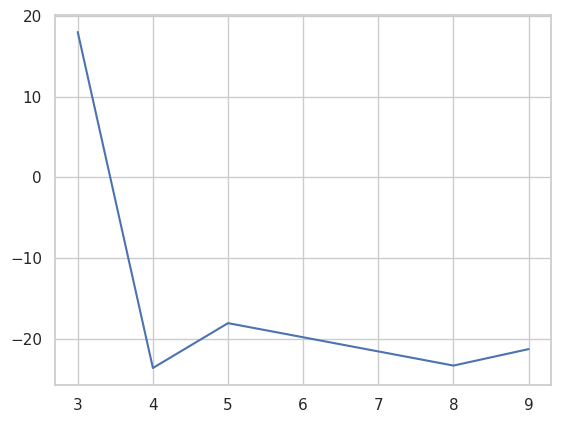

In [21]:
plt.plot(df_runs_6x6_seeded["final_energy"])

In [22]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # for aesthetics and potentially different plot types

df_runs_6x6_seeded_copy= df_runs_6x6_seeded.copy()
# Apply extraction
df_runs_6x6_seeded_copy['config_str'] = df_runs_6x6_seeded_copy['configuration/hyperparameters'].apply(safe_decode)
hyperparams_df = df_runs_6x6_seeded_copy['config_str'].apply(lambda s: pd.Series(extract_specific_hyperparams(s)))
df_runs_6x6_seeded_copy = pd.concat([df_runs_6x6_seeded_copy, hyperparams_df], axis=1)

# Filter out runs without seed or insufficient iterations
min_iterations = 1000
df_runs_6x6_seeded_copy_filtered = df_runs_6x6_seeded_copy[~df_runs_6x6_seeded_copy['seed'].isna()]
df_runs_6x6_seeded_copy_filtered = df_runs_6x6_seeded_copy_filtered[df_runs_6x6_seeded_copy_filtered['training/energy_real'].apply(len) >= min_iterations].copy()

# Add final values
df_runs_6x6_seeded_copy_filtered["final_energy"] = df_runs_6x6_seeded_copy_filtered["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6_seeded_copy_filtered["final_std"]    = df_runs_6x6_seeded_copy_filtered["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6_seeded_copy_filtered["final_stagg"]  = df_runs_6x6_seeded_copy_filtered["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)

print(f"Original runs: {len(df_runs_6x6_seeded_copy)}")
print(f"Runs after filtering (seed and >= {min_iterations} iterations): {len(df_runs_6x6_seeded_copy_filtered)}")

# Define exact values for 4x4
exact_energy_6x6 = -0.6783*36 # Your value from the plot
exact_stagg_abs_6x6 = 0.547 # Your value from the plot

Original runs: 5
Runs after filtering (seed and >= 1000 iterations): 5


In [26]:
df_runs_6x6_seeded_copy_filtered_low_energy=df_runs_6x6_seeded_copy_filtered[df_runs_6x6_seeded_copy_filtered['final_energy'] < -18]
df_runs_6x6_seeded_copy_filtered_low_energy['run_name'].unique().tolist()

['beta0.007__bs_256lr1.0e-04_loop1800x15_overlap_VMC/GNNprocnorm_h128_e64_K2',
 'beta0.02__bs_512lr7.0e-04_loop1800x15_overlap_VMC/GNNprocnorm_h128_e64_K2',
 'beta0.02__bs_512lr1.0e-04_loop1800x15_overlap_VMC/GNNprocnorm_h128_e64_K2',
 'beta0.007__bs_512lr1.0e-05_loop1210x15_overlap_VMC/GNNprocnorm_h128_e64_K2']

<Figure size 1400x1200 with 0 Axes>

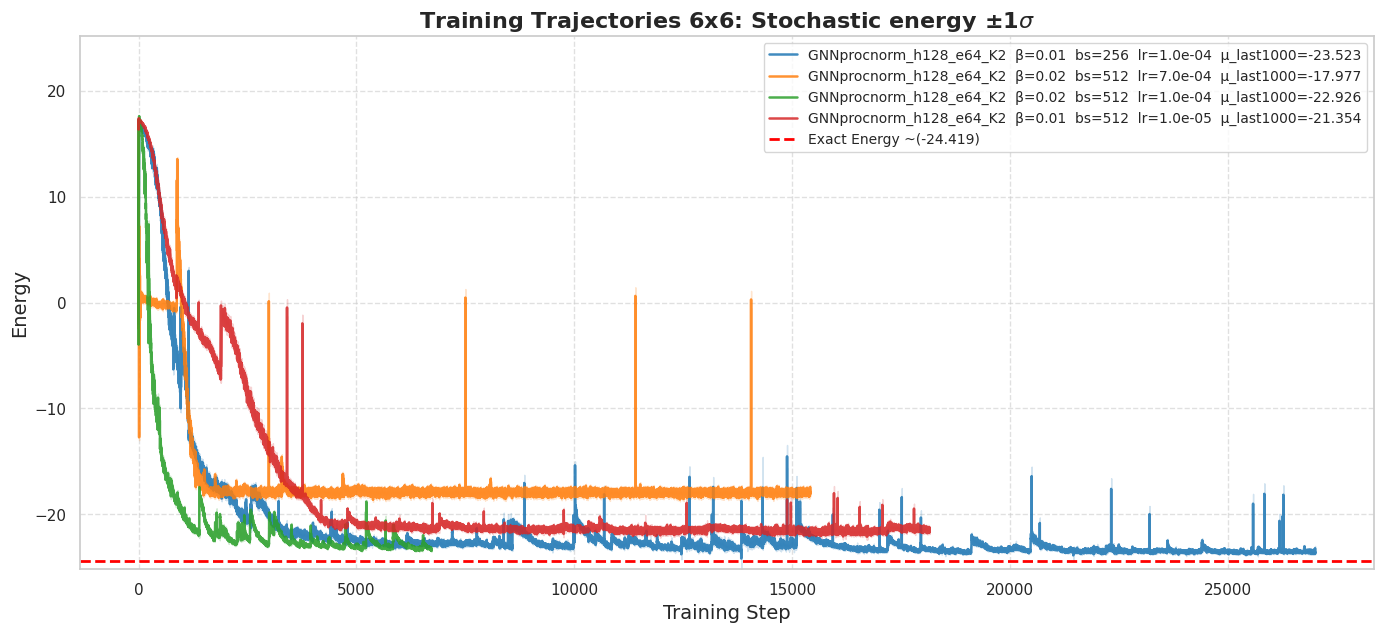

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Set seaborn style for prettier plots
sns.set_theme(style="whitegrid")

title_n=f"Training Trajectories {6}x{6}: Stochastic energy ±1" + r"$\sigma$"

plt.figure(figsize=(14, 12))

# calculate how far below exact_energy to clip
offset = 0.2 * abs(exact_energy)
ymin = exact_energy_6x6 - offset

# get a categorical palette
palette = sns.color_palette("tab10", n_colors=len(df_runs_6x6_seeded_copy_filtered_low_energy))

plt.figure(figsize=(14, 12))
ax1 = plt.subplot(2, 1, 1)

for (idx, run_data), color in zip(df_runs_6x6_seeded_copy_filtered_low_energy.iterrows(), palette):
    steps       = np.array(run_data['steps'])
    energy      = np.array(run_data['training/energy_real'])
    std_energy  = np.array(run_data['training/std_energy'])
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # extract a simpler run name
    run_name   = run_data.get('run_name', str(idx))
    m          = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name= m.group(0) if m else run_name.split('/')[-1]

    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

# 3. exact energy line
ax1.axhline(y=exact_energy_6x6,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ~({exact_energy_6x6:.3f})')

# 4. clip y-axis to 20% below the ground truth
ax1.set_ylim(bottom=ymin,top=-ymin)
ax1.set_title(title_n, fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
tf.get_logger().setLevel('ERROR')
models_6x6 = {}
for idx, d in enumerate(dirs_lowE):
    ckpt_paths=sorted(glob.glob(d+'/checkpoints/*.index', recursive=True))
    ckpt_idxs = sorted(glob.glob(os.path.join(d, 'checkpoints', '*.index')))
    ckpt_path = ckpt_idxs[-2][:-6]   # rimuovo '.index'
    print("→ checkpoint:", ckpt_path)
    hyperparams=extract_hyperparams_from_path(ckpt_path)
    model_temp=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params,0)
    optimizer_temp=snt.optimizers.Adam(hyperparams.sim_params.learning_rate,0.9,0.99)
    # prova forward prima del caricamento
    _ = model_temp(GT_Batch_init)

    # carica pesi
    load_model_from_path(
        model=model_temp,
        checkpoint_path=ckpt_path,  # load_model cerca i file .index ecc qui
        optimizer=optimizer_temp
    )

    # verifica forward dopo
    psi_val = model_temp(GT_Batch_init)[0]
    print(f"✔ Caricato modello da {d}, psi_val[0]={psi_val}")

    # chiave unica: basename + beta + bs
    run_key = os.path.basename(d) +f"_b{hyperparams.sim_params.beta}_bs{hyperparams.sim_params.batch_size}_lr{hyperparams.sim_params.learning_rate}"+"_"+str(idx)
    models[run_key] = {
        "model": model_temp,
        "hyperparams": hyperparams
    }

print("\nModelli caricati:", list(models.keys()))